# Prioritizing Risk Factors of Heart Failure from UK Biobank Using Explainable Artificial Intelligence

## Authors
Arkarachai Fungtammasan, Chiao-Feng Lin, Daniel Quang, Yih-Chii Hwang, Jason Chin

## Abstract
Predicting diseases using genetic variation, phenotypic traits, or environmental factors is one of the most important goals for precision health. With the recent advancement in machine learning techniques and the availability of large-scale genotype-phenotype databases, sophisticated machine learning methods have become widely adopted by the scientific community for predicting diseases. Many of these techniques offer more flexibility in terms of model assumption compared to traditional statistical methods and the ability to utilize a large amount of data as they have been developed to handle a larger amount of data in other scientific domains. However, the lack of interpretability and explainability of these models faces challenges in detecting errors and building trust. 

We demonstrate the use case of explainable artificial intelligence in predicting heart failure, one of the global major causes of death. We extracted the baseline data, blood measured, and reported lifestyle features from UK Biobank using UKB Research Analysis Platform. We experimented with the state-of-art black-box modeling tools such as LightGBM and XGBoost and estimated the contribution of each predictive feature using SHAP. In addition, we also used a recently developed glass-box machine learning model, Explainable Boosting Machine, which directly measures the impact of each predictor and their interactions instead of indirect inference. 

We found that sophisticated blackbox and glassbox machine learning methods yield similar predictive power. Age and sex are the most important features for most model classes regardless of algorithms, missing value handling strategies, or glassbox vs blackbox feature important analysis. The rest of the important features such as BMI, blood-measured C-reactive protein, cholesterol, Hemoglobin A1c are contributing to the minority of the population, but in large effect. Some features such as BMI also have non-linear contributions to model prediction. Our study exemplifies how machine learning could be used to study the impact of risk factors for individual patient. 



# Table of content
1. Load dataset in to instance with Spark 
2. Choose fields and put in Spark dataframe
3. Use readable field name and save as pandas pickle
4. Close Spark and setup data/library in ML_IP instance
5. Mark missing values
6. Process variables
7. Univariate analysis
8. Basic machine learning 
9. Interpretable and explainable ML




### Note that data exploration has not been included in this demo. Some data exploration could be done using UK Biobank cohort browser. 

# 1. Load dataset in to instance with Spark

### Launch Spark cluster HAIL-0.2.61 using instance mem1_ssd1_v2_x8

In [1]:
import dxdata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy import stats
import json
# Initialize dxdata engine
engine = dxdata.connect(dialect="hive+pyspark")
pt = engine.execute("SET spark.sql.shuffle.partitions=50").to_pandas()

In [2]:
DATASET_ID = "project-G59Y0xQJ51ZZFXpfFpfxQZzj:record-G59f2VjJk7QPJpF04v0619QG" # app46926_20210928164649.dataset
dataset = dxdata.load_dataset(id=DATASET_ID)  


### Dataset "entities" are virtual tables linked to one another.

The main entity is "participant" and corresponds to most pheno fields. Additional entities correspond to linked health care data.
Entities starting with "hesin" are for hospital records; entities starting with "gp" are for GP records, etc.

In [3]:
dataset.entities

[<Entity "participant">,
 <Entity "covid19_result_england">,
 <Entity "covid19_result_scotland">,
 <Entity "covid19_result_wales">,
 <Entity "death">,
 <Entity "death_cause">,
 <Entity "gp_clinical">,
 <Entity "gp_registrations">,
 <Entity "gp_scripts">,
 <Entity "hesin">,
 <Entity "hesin_critical">,
 <Entity "hesin_delivery">,
 <Entity "hesin_diag">,
 <Entity "hesin_maternity">,
 <Entity "hesin_oper">,
 <Entity "hesin_psych">]

### Accessing the main 'participant' entity

In [4]:
participant = dataset["participant"]

In [5]:
%%html
<style>
  table {margin-left: 0 !important;}
</style>

#### Selecting participant fields by field index, instance index, array index

For the main participant pheno entity, RAP uses field names with the following convention:

|Type of field|Syntax for field name|Example|
|:------------|---------------------|-------|
|Neither instanced nor arrayed|`p<FIELD>`|`p31`|
|Instanced but not arrayed|`p<FIELD>_i<INSTANCE>`|`p40005_i0`|
|Arrayed but not instanced|`p<FIELD>_a<ARRAY>`|`p41262_a0`|
|Instanced and arrayed|`p<FIELD>_i<INSTANCE>_a<ARRAY>`|`p93_i0_a0`|

If you know exactly the field names you want to work with, put them in a string array (we will see later how to use that):

#### Looking up fields by id

If you know the field id but you are not sure if it is instanced or arrayed, and want to grab all instances/arrays (if any), use this:

In [6]:
def field_names_for_id(field_id):
    from distutils.version import LooseVersion
    field_id = str(field_id)
    fields = participant.find_fields(name_regex=r'^p{}(_i\d+)?(_a\d+)?$'.format(field_id))
    return sorted([field.name for field in fields], key=lambda n: LooseVersion(n))

#### Looking up fields by title

If you remember part of the field title, use this:

In [7]:
def fields_by_title_keyword(keyword):
    import pandas as pd
    import re
    from distutils.version import LooseVersion
    regex = re.compile("^.*" + re.escape(keyword) + ".*$", re.I)
    fields = participant.find_fields(boolean_func=lambda f: getattr(f, "title") and bool(regex.match(f.title)))
    return pd.DataFrame(data=[(f.name, f.title, " > ".join(f.folder_path)) for f in sorted(fields, key=lambda n: LooseVersion(n.name))], columns=["name","title", "category"])

def field_names_by_title_keyword(keyword):
    return list(fields_by_title_keyword(keyword)["name"])

# 2. Choose fields and put in Spark dataframe

In [8]:
feature_code_mapping={'BMI': 21001,
 'HDL': 30760,
 'LDL': 30780,                    
 'HbA1c': 30750,
 'ICD10': 41270,
 'ICD9': 41271,
 'accleration_average':90012,
 'accleration_good_calibrate':90016,
 'accleration_good_wear_time':90015,
 'TV': 1070,
 'age': 21022,
 'alcohol': 1558,
 'all_MET': 22040,
 'c_reactive_protein': 30710,
 'computer': 1080,
 'cooked_vegie': 1289,
 'education': 6138,
 'fresh_fruit': 1309,
 'job': 22601,
 'moderate_activity': 894,
 'process_meat': 1349,
 'raw_vegie': 1299,
 'sex': 31,
 'sleep': 1160,
 'smoke': 20116,
 'total_cholesteral': 30690,
 'triglycerides': 30870,
 'townsend': 189,
 'vigorous_activity': 914,
 'walk': 874,
 'day_walk': 864,
 'day_moderate': 884,
 'day_vigorous': 904,
 'ethnic_background':21000
}
#was trying to change smoke from 20116 to 22506, but revert back due to high missing value

In [9]:
HF_paper_list=[
"age",
"sex",
"BMI",
"alcohol",
"sleep",
"walk",
"moderate_activity",
"vigorous_activity",
"TV",
"computer",
"smoke",
"accleration_average",
'accleration_good_calibrate',
'accleration_good_wear_time',
"townsend",
"total_cholesteral",
"ICD10",
"ICD9",
"day_vigorous",
"day_moderate",
"day_walk",
"ethnic_background",
"HDL",
"LDL",
"triglycerides",
"HbA1c",
"c_reactive_protein",
"cooked_vegie",
"raw_vegie",
"fresh_fruit",
"process_meat",
]

In [10]:
feature_list=HF_paper_list

In [12]:
field_names = [] 
for feature in feature_list:
    print(feature)
    print(field_names_for_id(feature_code_mapping[feature]))
    field_names+=field_names_for_id(feature_code_mapping[feature])

age
['p21022']
sex
['p31']
BMI
['p21001_i0', 'p21001_i1', 'p21001_i2', 'p21001_i3']
alcohol
['p1558_i0', 'p1558_i1', 'p1558_i2', 'p1558_i3']
sleep
['p1160_i0', 'p1160_i1', 'p1160_i2', 'p1160_i3']
walk
['p874_i0', 'p874_i1', 'p874_i2', 'p874_i3']
moderate_activity
['p894_i0', 'p894_i1', 'p894_i2', 'p894_i3']
vigorous_activity
['p914_i0', 'p914_i1', 'p914_i2', 'p914_i3']
TV
['p1070_i0', 'p1070_i1', 'p1070_i2', 'p1070_i3']
computer
['p1080_i0', 'p1080_i1', 'p1080_i2', 'p1080_i3']
smoke
['p20116_i0', 'p20116_i1', 'p20116_i2', 'p20116_i3']
accleration_average
['p90012']
accleration_good_calibrate
['p90016']
accleration_good_wear_time
['p90015']
townsend
['p189']
total_cholesteral
['p30690_i0', 'p30690_i1']
ICD10
['p41270']
ICD9
['p41271']
day_vigorous
['p904_i0', 'p904_i1', 'p904_i2', 'p904_i3']
day_moderate
['p884_i0', 'p884_i1', 'p884_i2', 'p884_i3']
day_walk
['p864_i0', 'p864_i1', 'p864_i2', 'p864_i3']
ethnic_background
['p21000_i0', 'p21000_i1', 'p21000_i2']
HDL
['p30760_i0', 'p30760_i1

### Grabbing fields into a spark dataframe

In [13]:
engine = dxdata.connect(dialect="hive+pyspark")
df = participant.retrieve_fields(engine=engine, names=field_names)

In [14]:
ashg_df_pandas=df.toPandas()

# 3. Use readable field name and save as pandas pickle

In [16]:
characters_to_remove = "[-\|\,]"
title_dict={}
for field_name in field_names:
    new_name=participant[field_name].title
    new_name = re.sub(characters_to_remove, "", new_name)
    new_name = new_name.replace(' ','_')
    new_name = new_name.replace('_/_','_')
    new_name = re.sub("__+", "_", new_name)
    title_dict[field_name]=new_name
title_dict

{'p21022': 'Age_at_recruitment',
 'p31': 'Sex',
 'p21001_i0': 'Body_mass_index_(BMI)_Instance_0',
 'p21001_i1': 'Body_mass_index_(BMI)_Instance_1',
 'p21001_i2': 'Body_mass_index_(BMI)_Instance_2',
 'p21001_i3': 'Body_mass_index_(BMI)_Instance_3',
 'p1558_i0': 'Alcohol_intake_frequency._Instance_0',
 'p1558_i1': 'Alcohol_intake_frequency._Instance_1',
 'p1558_i2': 'Alcohol_intake_frequency._Instance_2',
 'p1558_i3': 'Alcohol_intake_frequency._Instance_3',
 'p1160_i0': 'Sleep_duration_Instance_0',
 'p1160_i1': 'Sleep_duration_Instance_1',
 'p1160_i2': 'Sleep_duration_Instance_2',
 'p1160_i3': 'Sleep_duration_Instance_3',
 'p874_i0': 'Duration_of_walks_Instance_0',
 'p874_i1': 'Duration_of_walks_Instance_1',
 'p874_i2': 'Duration_of_walks_Instance_2',
 'p874_i3': 'Duration_of_walks_Instance_3',
 'p894_i0': 'Duration_of_moderate_activity_Instance_0',
 'p894_i1': 'Duration_of_moderate_activity_Instance_1',
 'p894_i2': 'Duration_of_moderate_activity_Instance_2',
 'p894_i3': 'Duration_of_mod

In [17]:
%%time
ashg_df_pandas.rename(columns=title_dict,inplace=True)

CPU times: user 98.2 ms, sys: 15.8 ms, total: 114 ms
Wall time: 112 ms


### Save to pickle, so you don't have to use cluster

In [18]:
ashg_df_pandas.describe()

,Smoking_status_Instance_0,Smoking_status_Instance_1,Smoking_status_Instance_2,Smoking_status_Instance_3,Overall_acceleration_average,Data_quality_good_calibration,Data_quality_good_wear_time,Townsend_deprivation_index_at_recruitment,Cholesterol_Instance_0,Cholesterol_Instance_1,...,Salad_raw_vegetable_intake_Instance_2,Salad_raw_vegetable_intake_Instance_3,Fresh_fruit_intake_Instance_0,Fresh_fruit_intake_Instance_1,Fresh_fruit_intake_Instance_2,Fresh_fruit_intake_Instance_3,Processed_meat_intake_Instance_0,Processed_meat_intake_Instance_1,Processed_meat_intake_Instance_2,Processed_meat_intake_Instance_3
count,501538.000000,20335.000000,48636.000000,4475.000000,103673.000000,103673.000000,103673.000000,501806.000000,469521.000000,17876.000000,...,48636.000000,4475.000000,501536.000000,20335.000000,48636.000000,4475.000000,501534.000000,20335.000000,48636.000000,4475.000000
mean,0.543903,0.437374,0.402870,0.354190,27.423395,0.999894,0.932548,-1.293774,5.692427,5.697295,...,1.745621,1.590615,1.886126,1.799262,1.950757,1.860112,1.857308,1.827293,1.778004,1.735642
std,0.713089,0.605782,0.591328,0.558113,13.995965,0.010300,0.250805,3.095026,1.144950,1.187448,...,3.391990,3.286499,2.678551,2.724530,2.699299,2.762238,1.076347,1.070989,1.065821,1.066651
min,-3.000000,-3.000000,-3.000000,-3.000000,0.000000,0.000000,0.000000,-6.258260,0.601000,1.869000,...,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-3.000000,-3.000000,-3.000000,-1.000000
25%,0.000000,0.000000,0.000000,0.000000,21.840000,1.000000,1.000000,-3.639820,4.906000,4.871000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,26.740000,1.000000,1.000000,-2.135390,5.650000,5.667500,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
75%,1.000000,1.000000,1.000000,1.000000,32.340000,1.000000,1.000000,0.549853,6.424000,6.484000,...,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
max,2.000000,2.000000,2.000000,2.000000,2411.070000,1.000000,1.000000,11.001300,15.460000,11.366000,...,50.000000,25.000000,50.000000,30.000000,50.000000,40.000000,5.000000,5.000000,5.000000,5.000000


In [19]:
ashg_df_pandas.to_pickle("./ashg_df_pandas.pkl")

In [21]:
! dx mkdir ASHGdemo
! dx upload ashg_df_pandas.pkl --path /ASHGdemo/ashg_df_pandas.pkl

[===========================================================>] Uploaded 391,409,047 of 391,409,047 bytes (100%) ashg_df_pandas.pkl
ID                    file-G5J14B8J51ZyJ9Z54b4KQb7V
Class                 file
Project               project-G59Y0xQJ51ZZFXpfFpfxQZzj
Folder                /ASHGdemo
Name                  ashg_df_pandas
State                 closing
Visibility            visible
Types                 -
Properties            -
Tags                  -
Outgoing links        -
Created               Sun Oct  3 20:27:21 2021
Created by            chai_rap
 via the job          job-G5J0J28J51ZvV3pvP5485z44
Last modified         Sun Oct  3 20:27:25 2021
Media type            
archivalState         "live"
cloudAccount          "cloudaccount-dnanexus"


### Check in the project if pandas pickle file have been completely uploaded

# 4. Close Spark and setup data/library in ML_IP instance

### Close Spark cluster and launch a Python_R instance with mem1_ssd1_v2_x8 instead

This is done using UKB-RAP UI.

### On new instance, install new version of Seaborn

In [1]:
pip install seaborn==0.11.1

     |████████████████████████████████| 285 kB 30.4 MB/s eta 0:00:01
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.10.1
    Uninstalling seaborn-0.10.1:
      Successfully uninstalled seaborn-0.10.1
Note: you may need to restart the kernel to use updated packages.


#### Now restart kernel to make new Seaborn in effect.

### Import required library

In [2]:
from IPython.display import Image

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy import stats
import json

In [4]:
print(sns.__version__)

0.11.1


### Load pandas pickle

In [5]:
! dx download ASHGdemo/ashg_df_pandas.pkl

[===========================================================>] Completed 391,409,047 of 391,409,047 bytes (100%) /opt/notebooks/ashg_df_pandas.pkll


In [6]:
ashg_df_pandas=pd.read_pickle("./ashg_df_pandas.pkl")

In [8]:
ashg_df_pandas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502430 entries, 0 to 502429
Data columns (total 88 columns):
eid                                                                         502430 non-null object
Smoking_status_Instance_0                                                   501538 non-null float64
Smoking_status_Instance_1                                                   20335 non-null float64
Smoking_status_Instance_2                                                   48636 non-null float64
Smoking_status_Instance_3                                                   4475 non-null float64
Overall_acceleration_average                                                103673 non-null float64
Data_quality_good_calibration                                               103673 non-null float64
Data_quality_good_wear_time                                                 103673 non-null float64
Townsend_deprivation_index_at_recruitment                                   501806 non-null fl

# 5. Mark missing values

In [9]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


In [10]:
ashg_df_pandas.describe()

,Smoking_status_Instance_0,Smoking_status_Instance_1,Smoking_status_Instance_2,Smoking_status_Instance_3,Overall_acceleration_average,Data_quality_good_calibration,Data_quality_good_wear_time,Townsend_deprivation_index_at_recruitment,Cholesterol_Instance_0,Cholesterol_Instance_1,HDL_cholesterol_Instance_0,HDL_cholesterol_Instance_1,Glycated_haemoglobin_(HbA1c)_Instance_0,Glycated_haemoglobin_(HbA1c)_Instance_1,Creactive_protein_Instance_0,Creactive_protein_Instance_1,LDL_direct_Instance_0,LDL_direct_Instance_1,Triglycerides_Instance_0,Triglycerides_Instance_1,Age_at_recruitment,Body_mass_index_(BMI)_Instance_0,Body_mass_index_(BMI)_Instance_1,Body_mass_index_(BMI)_Instance_2,Body_mass_index_(BMI)_Instance_3,Ethnic_background_Instance_0,Ethnic_background_Instance_1,Ethnic_background_Instance_2,Sex,Alcohol_intake_frequency._Instance_0,Alcohol_intake_frequency._Instance_1,Alcohol_intake_frequency._Instance_2,Alcohol_intake_frequency._Instance_3,Sleep_duration_Instance_0,Sleep_duration_Instance_1,Sleep_duration_Instance_2,Sleep_duration_Instance_3,Duration_of_walks_Instance_0,Duration_of_walks_Instance_1,Duration_of_walks_Instance_2,Duration_of_walks_Instance_3,Duration_of_moderate_activity_Instance_0,Duration_of_moderate_activity_Instance_1,Duration_of_moderate_activity_Instance_2,Duration_of_moderate_activity_Instance_3,Duration_of_vigorous_activity_Instance_0,Duration_of_vigorous_activity_Instance_1,Duration_of_vigorous_activity_Instance_2,Duration_of_vigorous_activity_Instance_3,Time_spent_watching_television_(TV)_Instance_0,Time_spent_watching_television_(TV)_Instance_1,Time_spent_watching_television_(TV)_Instance_2,Time_spent_watching_television_(TV)_Instance_3,Time_spent_using_computer_Instance_0,Time_spent_using_computer_Instance_1,Time_spent_using_computer_Instance_2,Time_spent_using_computer_Instance_3,Number_of_days/week_of_vigorous_physical_activity_10+_minutes_Instance_0,Number_of_days/week_of_vigorous_physical_activity_10+_minutes_Instance_1,Number_of_days/week_of_vigorous_physical_activity_10+_minutes_Instance_2,Number_of_days/week_of_vigorous_physical_activity_10+_minutes_Instance_3,Number_of_days/week_of_moderate_physical_activity_10+_minutes_Instance_0,Number_of_days/week_of_moderate_physical_activity_10+_minutes_Instance_1,Number_of_days/week_of_moderate_physical_activity_10+_minutes_Instance_2,Number_of_days/week_of_moderate_physical_activity_10+_minutes_Instance_3,Number_of_days/week_walked_10+_minutes_Instance_0,Number_of_days/week_walked_10+_minutes_Instance_1,Number_of_days/week_walked_10+_minutes_Instance_2,Number_of_days/week_walked_10+_minutes_Instance_3,Cooked_vegetable_intake_Instance_0,Cooked_vegetable_intake_Instance_1,Cooked_vegetable_intake_Instance_2,Cooked_vegetable_intake_Instance_3,Salad_raw_vegetable_intake_Instance_0,Salad_raw_vegetable_intake_Instance_1,Salad_raw_vegetable_intake_Instance_2,Salad_raw_vegetable_intake_Instance_3,Fresh_fruit_intake_Instance_0,Fresh_fruit_intake_Instance_1,Fresh_fruit_intake_Instance_2,Fresh_fruit_intake_Instance_3,Processed_meat_intake_Instance_0,Processed_meat_intake_Instance_1,Processed_meat_intake_Instance_2,Processed_meat_intake_Instance_3
count,501538.000000,20335.000000,48636.000000,4475.000000,103673.000000,103673.000000,103673.000000,501806.000000,469521.000000,17876.000000,429810.000000,15690.000000,466434.000000,14267.000000,468500.000000,17836.000000,468638.000000,17836.000000,469146.000000,17843.000000,502429.000000,499325.000000,20298.000000,47357.000000,4480.000000,501531.000000,20335.000000,11667.000000,502429.000000,501532.00000,20335.000000,48636.000000,4475.000000,501542.000000,20335.000000,48636.000000,4475.000000,477806.000000,19692.000000,47848.000000,4420.000000,410981.000000,17646.000000,43970.000000,4059.000000,294690.000000,12986.000000,33100.000000,3039.000000,501546.000000,20335.000000,48636.000000,4475.000000,497776.000000,20335.000000,48636.000000,4475.000000,501551.000000,20335.000000,48636.000000,4475.000000,501551.000000,20335.0

### Observations
1. There are both NaN and unexpected negative values. These values should be processed to have correct representation. 
2. Q1, Q2, Q3 shows that most of these features have discrete values. Some of them should be nominal and ordinal. 


In [11]:
ashg_df_pandas.isna().sum()

eid                                                                              0
Smoking_status_Instance_0                                                      892
Smoking_status_Instance_1                                                   482095
Smoking_status_Instance_2                                                   453794
Smoking_status_Instance_3                                                   497955
Overall_acceleration_average                                                398757
Data_quality_good_calibration                                               398757
Data_quality_good_wear_time                                                 398757
Townsend_deprivation_index_at_recruitment                                      624
Cholesterol_Instance_0                                                       32909
Cholesterol_Instance_1                                                      484554
HDL_cholesterol_Instance_0                                                   72620
HDL_

In [12]:
ashg_df_pandas.replace({
    'Alcohol_intake_frequency._Instance_0':{-3:np.nan},
    'Alcohol_intake_frequency._Instance_1':{-3:np.nan},
    'Alcohol_intake_frequency._Instance_2':{-3:np.nan},
    'Alcohol_intake_frequency._Instance_3':{-3:np.nan},
    'Overall_health_rating_Instance_0':{-3:np.nan,-1:np.nan},
    'Overall_health_rating_Instance_1':{-3:np.nan,-1:np.nan},
    'Overall_health_rating_Instance_2':{-3:np.nan,-1:np.nan},
    'Overall_health_rating_Instance_3':{-3:np.nan,-1:np.nan},
    'Smoking_status_Instance_0':{-3:np.nan},
    'Smoking_status_Instance_1':{-3:np.nan},
    'Smoking_status_Instance_2':{-3:np.nan},
    'Smoking_status_Instance_3':{-3:np.nan},
    'Sleep_duration_Instance_0':{-3:np.nan,-1:np.nan},
    'Sleep_duration_Instance_1':{-3:np.nan,-1:np.nan},
    'Sleep_duration_Instance_2':{-3:np.nan,-1:np.nan},
    'Sleep_duration_Instance_3':{-3:np.nan,-1:np.nan},
    'Duration_of_walks_Instance_0':{-3:np.nan,-1:np.nan},
    'Duration_of_walks_Instance_1':{-3:np.nan,-1:np.nan},
    'Duration_of_walks_Instance_2':{-3:np.nan,-1:np.nan},
    'Duration_of_walks_Instance_3':{-3:np.nan,-1:np.nan},
    'Duration_of_moderate_activity_Instance_0':{-3:np.nan,-1:np.nan},
    'Duration_of_moderate_activity_Instance_1':{-3:np.nan,-1:np.nan},
    'Duration_of_moderate_activity_Instance_2':{-3:np.nan,-1:np.nan},
    'Duration_of_moderate_activity_Instance_3':{-3:np.nan,-1:np.nan},
    'Duration_of_vigorous_activity_Instance_0':{-3:np.nan,-1:np.nan},
    'Duration_of_vigorous_activity_Instance_1':{-3:np.nan,-1:np.nan},
    'Duration_of_vigorous_activity_Instance_2':{-3:np.nan,-1:np.nan},
    'Duration_of_vigorous_activity_Instance_3':{-3:np.nan,-1:np.nan},
    'Time_spent_watching_television_(TV)_Instance_0':{-3:np.nan,-1:np.nan,-10:0},
    'Time_spent_watching_television_(TV)_Instance_1':{-3:np.nan,-1:np.nan,-10:0},
    'Time_spent_watching_television_(TV)_Instance_2':{-3:np.nan,-1:np.nan,-10:0},
    'Time_spent_watching_television_(TV)_Instance_3':{-3:np.nan,-1:np.nan,-10:0},
    'Time_spent_using_computer_Instance_0':{-3:np.nan,-1:np.nan,-10:0},
    'Time_spent_using_computer_Instance_1':{-3:np.nan,-1:np.nan,-10:0},
    'Time_spent_using_computer_Instance_2':{-3:np.nan,-1:np.nan,-10:0},
    'Time_spent_using_computer_Instance_3':{-3:np.nan,-1:np.nan,-10:0},
    'Number_of_days/week_of_vigorous_physical_activity_10+_minutes_Instance_0':{-3:np.nan,-1:np.nan},
    'Number_of_days/week_of_vigorous_physical_activity_10+_minutes_Instance_1':{-3:np.nan,-1:np.nan},
    'Number_of_days/week_of_vigorous_physical_activity_10+_minutes_Instance_2':{-3:np.nan,-1:np.nan},
    'Number_of_days/week_of_vigorous_physical_activity_10+_minutes_Instance_3':{-3:np.nan,-1:np.nan},
    'Number_of_days/week_of_moderate_physical_activity_10+_minutes_Instance_0':{-3:np.nan,-1:np.nan},
    'Number_of_days/week_of_moderate_physical_activity_10+_minutes_Instance_1':{-3:np.nan,-1:np.nan},
    'Number_of_days/week_of_moderate_physical_activity_10+_minutes_Instance_2':{-3:np.nan,-1:np.nan},
    'Number_of_days/week_of_moderate_physical_activity_10+_minutes_Instance_3':{-3:np.nan,-1:np.nan},
    'Number_of_days/week_walked_10+_minutes_Instance_0':{-3:np.nan,-2:np.nan,-1:np.nan},
    'Number_of_days/week_walked_10+_minutes_Instance_1':{-3:np.nan,-2:np.nan,-1:np.nan},
    'Number_of_days/week_walked_10+_minutes_Instance_2':{-3:np.nan,-2:np.nan,-1:np.nan},
    'Number_of_days/week_walked_10+_minutes_Instance_3':{-3:np.nan,-2:np.nan,-1:np.nan},
    'Ethnic_background_Instance_0':{-1:np.nan,-3:np.nan},
    'Ethnic_background_Instance_1':{-1:np.nan,-3:np.nan},
    'Ethnic_background_Instance_2':{-1:np.nan,-3:np.nan},
    'Cooked_vegetable_intake_Instance_0':{-3:np.nan,-1:np.nan,-10:0},
    'Cooked_vegetable_intake_Instance_1':{-3:np.nan,-1:np.nan,-10:0},
    'Cooked_vegetable_intake_Instance_2':{-3:np.nan,-1:np.nan,-10:0},
    'Cooked_vegetable_intake_Instance_3':{-3:np.nan,-1:np.nan,-10:0},
    'Salad_raw_vegetable_intake_Instance_0':{-3:np.nan,-1:np.nan,-10:0},
    'Salad_raw_vegetable_intake_Instance_1':{-3:np.nan,-1:np.nan,-10:0},
    'Salad_raw_vegetable_intake_Instance_2':{-3:np.nan,-1:np.nan,-10:0},
    'Salad_raw_vegetable_intake_Instance_3':{-3:np.nan,-1:np.nan,-10:0},
    'Fresh_fruit_intake_Instance_0':{-3:np.nan,-1:np.nan,-10:0},
    'Fresh_fruit_intake_Instance_1':{-3:np.nan,-1:np.nan,-10:0},
    'Fresh_fruit_intake_Instance_2':{-3:np.nan,-1:np.nan,-10:0},
    'Fresh_fruit_intake_Instance_3':{-3:np.nan,-1:np.nan,-10:0},
    'Processed_meat_intake_Instance_0':{-3:np.nan,-1:np.nan},
    'Processed_meat_intake_Instance_1':{-3:np.nan,-1:np.nan},
    'Processed_meat_intake_Instance_2':{-3:np.nan,-1:np.nan},
    'Processed_meat_intake_Instance_3':{-3:np.nan,-1:np.nan},
                     },inplace=True)

### Process Overall_acceleration_average based on two other field which indicate low data quality

In [13]:
ashg_df_pandas['Overall_acceleration_average'][(ashg_df_pandas['Data_quality_good_calibration'] != 1) | (ashg_df_pandas['Data_quality_good_wear_time'] != 1)]=np.nan

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [14]:
ashg_df_pandas.describe()

,Smoking_status_Instance_0,Smoking_status_Instance_1,Smoking_status_Instance_2,Smoking_status_Instance_3,Overall_acceleration_average,Data_quality_good_calibration,Data_quality_good_wear_time,Townsend_deprivation_index_at_recruitment,Cholesterol_Instance_0,Cholesterol_Instance_1,HDL_cholesterol_Instance_0,HDL_cholesterol_Instance_1,Glycated_haemoglobin_(HbA1c)_Instance_0,Glycated_haemoglobin_(HbA1c)_Instance_1,Creactive_protein_Instance_0,Creactive_protein_Instance_1,LDL_direct_Instance_0,LDL_direct_Instance_1,Triglycerides_Instance_0,Triglycerides_Instance_1,Age_at_recruitment,Body_mass_index_(BMI)_Instance_0,Body_mass_index_(BMI)_Instance_1,Body_mass_index_(BMI)_Instance_2,Body_mass_index_(BMI)_Instance_3,Ethnic_background_Instance_0,Ethnic_background_Instance_1,Ethnic_background_Instance_2,Sex,Alcohol_intake_frequency._Instance_0,Alcohol_intake_frequency._Instance_1,Alcohol_intake_frequency._Instance_2,Alcohol_intake_frequency._Instance_3,Sleep_duration_Instance_0,Sleep_duration_Instance_1,Sleep_duration_Instance_2,Sleep_duration_Instance_3,Duration_of_walks_Instance_0,Duration_of_walks_Instance_1,Duration_of_walks_Instance_2,Duration_of_walks_Instance_3,Duration_of_moderate_activity_Instance_0,Duration_of_moderate_activity_Instance_1,Duration_of_moderate_activity_Instance_2,Duration_of_moderate_activity_Instance_3,Duration_of_vigorous_activity_Instance_0,Duration_of_vigorous_activity_Instance_1,Duration_of_vigorous_activity_Instance_2,Duration_of_vigorous_activity_Instance_3,Time_spent_watching_television_(TV)_Instance_0,Time_spent_watching_television_(TV)_Instance_1,Time_spent_watching_television_(TV)_Instance_2,Time_spent_watching_television_(TV)_Instance_3,Time_spent_using_computer_Instance_0,Time_spent_using_computer_Instance_1,Time_spent_using_computer_Instance_2,Time_spent_using_computer_Instance_3,Number_of_days/week_of_vigorous_physical_activity_10+_minutes_Instance_0,Number_of_days/week_of_vigorous_physical_activity_10+_minutes_Instance_1,Number_of_days/week_of_vigorous_physical_activity_10+_minutes_Instance_2,Number_of_days/week_of_vigorous_physical_activity_10+_minutes_Instance_3,Number_of_days/week_of_moderate_physical_activity_10+_minutes_Instance_0,Number_of_days/week_of_moderate_physical_activity_10+_minutes_Instance_1,Number_of_days/week_of_moderate_physical_activity_10+_minutes_Instance_2,Number_of_days/week_of_moderate_physical_activity_10+_minutes_Instance_3,Number_of_days/week_walked_10+_minutes_Instance_0,Number_of_days/week_walked_10+_minutes_Instance_1,Number_of_days/week_walked_10+_minutes_Instance_2,Number_of_days/week_walked_10+_minutes_Instance_3,Cooked_vegetable_intake_Instance_0,Cooked_vegetable_intake_Instance_1,Cooked_vegetable_intake_Instance_2,Cooked_vegetable_intake_Instance_3,Salad_raw_vegetable_intake_Instance_0,Salad_raw_vegetable_intake_Instance_1,Salad_raw_vegetable_intake_Instance_2,Salad_raw_vegetable_intake_Instance_3,Fresh_fruit_intake_Instance_0,Fresh_fruit_intake_Instance_1,Fresh_fruit_intake_Instance_2,Fresh_fruit_intake_Instance_3,Processed_meat_intake_Instance_0,Processed_meat_intake_Instance_1,Processed_meat_intake_Instance_2,Processed_meat_intake_Instance_3
count,499481.000000,20284.000000,48477.000000,4461.000000,96676.000000,103673.000000,103673.000000,501806.000000,469521.000000,17876.000000,429810.000000,15690.000000,466434.000000,14267.000000,468500.000000,17836.000000,468638.000000,17836.000000,469146.000000,17843.000000,502429.000000,499325.000000,20298.000000,47357.000000,4480.000000,499653.000000,20278.000000,11642.000000,502429.000000,500929.000000,20331.000000,48617.000000,4475.000000,498215.000000,20276.000000,48505.000000,4465.000000,425515.000000,18182.000000,44394.000000,4158.000000,368362.000000,16518.000000,41209.000000,3872.000000,269441.000000,12257.000000,31164.000000,2924.000000,497016.000000,20265.000000,48510.000000,4467.000000,493068.000000,20260.000000,48488.000000,4467.000000,474856.000000,19882.000000,47630.000000,4399.000000,475165.000000,19759.0

# 6. Process variables

## 6.1 Combine multiple-instance (multiple-measured) features

How to combine multiple measured features is a research question.

In [15]:
walk=np.nanmean(np.array([ashg_df_pandas['Number_of_days/week_walked_10+_minutes_Instance_0']*ashg_df_pandas['Duration_of_walks_Instance_0'],
                    ashg_df_pandas['Number_of_days/week_walked_10+_minutes_Instance_1']*ashg_df_pandas['Duration_of_walks_Instance_1'],
                    ashg_df_pandas['Number_of_days/week_walked_10+_minutes_Instance_2']*ashg_df_pandas['Duration_of_walks_Instance_2'],
                    ashg_df_pandas['Number_of_days/week_walked_10+_minutes_Instance_3']*ashg_df_pandas['Duration_of_walks_Instance_3']
                   ]),axis=0)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


In [16]:
moderate=np.nanmean(np.array([ashg_df_pandas['Number_of_days/week_of_moderate_physical_activity_10+_minutes_Instance_0']*ashg_df_pandas['Duration_of_moderate_activity_Instance_0'],
                              ashg_df_pandas['Number_of_days/week_of_moderate_physical_activity_10+_minutes_Instance_1']*ashg_df_pandas['Duration_of_moderate_activity_Instance_1'],
                              ashg_df_pandas['Number_of_days/week_of_moderate_physical_activity_10+_minutes_Instance_2']*ashg_df_pandas['Duration_of_moderate_activity_Instance_2'],
                              ashg_df_pandas['Number_of_days/week_of_moderate_physical_activity_10+_minutes_Instance_3']*ashg_df_pandas['Duration_of_moderate_activity_Instance_3'],
                             ]),axis=0)



/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


In [17]:
vigorous=np.nanmean(np.array([ashg_df_pandas['Number_of_days/week_of_vigorous_physical_activity_10+_minutes_Instance_0']*ashg_df_pandas['Duration_of_vigorous_activity_Instance_0'],
                              ashg_df_pandas['Number_of_days/week_of_vigorous_physical_activity_10+_minutes_Instance_1']*ashg_df_pandas['Duration_of_vigorous_activity_Instance_1'],
                              ashg_df_pandas['Number_of_days/week_of_vigorous_physical_activity_10+_minutes_Instance_2']*ashg_df_pandas['Duration_of_vigorous_activity_Instance_2'],
                              ashg_df_pandas['Number_of_days/week_of_vigorous_physical_activity_10+_minutes_Instance_3']*ashg_df_pandas['Duration_of_vigorous_activity_Instance_3'],
                             ]),axis=0)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


In [18]:
bmi_average=ashg_df_pandas[['Body_mass_index_(BMI)_Instance_0','Body_mass_index_(BMI)_Instance_1','Body_mass_index_(BMI)_Instance_2','Body_mass_index_(BMI)_Instance_3']].mean(skipna=True,axis=1)

In [19]:
def one_return(dataset):
    output=dataset.dropna().unique()
    if len(output)==1:
        return output[0]
    else:
        return np.nan

In [20]:
ethnic=ashg_df_pandas[['Ethnic_background_Instance_0','Ethnic_background_Instance_1','Ethnic_background_Instance_2']].apply(one_return,axis=1)


In [21]:
caucasian=ethnic.map(lambda x: 1 if (str(x).startswith('1')) else 0)
caucasian2=caucasian.astype('category')
caucasian2.value_counts()

1    472040
0     30390
dtype: int64

In [22]:
caucasian=caucasian2

In [23]:
ethnic2=ethnic.astype('category')
ethnic2.value_counts()

1001.0    442323
1003.0     16148
1002.0     13017
3001.0      5948
4001.0      4513
6.0         4507
4002.0      3390
3002.0      1833
3004.0      1800
5.0         1571
2004.0      1017
2003.0       825
2001.0       617
1.0          552
2002.0       421
3003.0       236
4003.0       121
2.0           49
3.0           44
4.0           26
dtype: int64

In [24]:
sleep=ashg_df_pandas[['Sleep_duration_Instance_0','Sleep_duration_Instance_1','Sleep_duration_Instance_2','Sleep_duration_Instance_3']].mean(skipna=True,axis=1)
alcohol=ashg_df_pandas[['Alcohol_intake_frequency._Instance_0','Alcohol_intake_frequency._Instance_1','Alcohol_intake_frequency._Instance_2','Alcohol_intake_frequency._Instance_3',]].mean(skipna=True,axis=1)
tv=ashg_df_pandas[['Time_spent_watching_television_(TV)_Instance_0','Time_spent_watching_television_(TV)_Instance_1','Time_spent_watching_television_(TV)_Instance_2','Time_spent_watching_television_(TV)_Instance_3',]].mean(skipna=True,axis=1)
computer=ashg_df_pandas[['Time_spent_using_computer_Instance_0','Time_spent_using_computer_Instance_1','Time_spent_using_computer_Instance_2','Time_spent_using_computer_Instance_3',]].mean(skipna=True,axis=1)
smoking=ashg_df_pandas[['Smoking_status_Instance_0','Smoking_status_Instance_1','Smoking_status_Instance_2','Smoking_status_Instance_3',]].mean(skipna=True,axis=1)
cholesterol=ashg_df_pandas[['Cholesterol_Instance_0','Cholesterol_Instance_1']].mean(skipna=True,axis=1)
HDL=ashg_df_pandas[['HDL_cholesterol_Instance_0','HDL_cholesterol_Instance_1']].mean(skipna=True,axis=1)
LDL=ashg_df_pandas[['LDL_direct_Instance_0','LDL_direct_Instance_1']].mean(skipna=True,axis=1)
triglyceride=ashg_df_pandas[['Triglycerides_Instance_0','Triglycerides_Instance_1']].mean(skipna=True,axis=1)
c_reactive=ashg_df_pandas[['Creactive_protein_Instance_0','Creactive_protein_Instance_1']].mean(skipna=True,axis=1)
HbA1c=ashg_df_pandas[['Glycated_haemoglobin_(HbA1c)_Instance_0','Glycated_haemoglobin_(HbA1c)_Instance_1']].mean(skipna=True,axis=1)
raw_vegie=ashg_df_pandas[['Salad_raw_vegetable_intake_Instance_0','Salad_raw_vegetable_intake_Instance_1','Salad_raw_vegetable_intake_Instance_2','Salad_raw_vegetable_intake_Instance_3']].mean(skipna=True,axis=1)
cook_vegie=ashg_df_pandas[['Cooked_vegetable_intake_Instance_0','Cooked_vegetable_intake_Instance_1','Cooked_vegetable_intake_Instance_2','Cooked_vegetable_intake_Instance_3']].mean(skipna=True,axis=1)
fresh_fruit=ashg_df_pandas[['Fresh_fruit_intake_Instance_0','Fresh_fruit_intake_Instance_1','Fresh_fruit_intake_Instance_2','Fresh_fruit_intake_Instance_3']].mean(skipna=True,axis=1)
process_meat=ashg_df_pandas[['Processed_meat_intake_Instance_0','Processed_meat_intake_Instance_1','Processed_meat_intake_Instance_2','Processed_meat_intake_Instance_3']].mean(skipna=True,axis=1)


In [25]:
# Make reverse of normal alcohol to high number mean consuming more alcohol
alcohol_intake=6-alcohol

In [26]:
alcohol.head()

0    4.0
1    2.0
2    3.0
3    3.5
4    2.0
dtype: float64

In [27]:
alcohol_intake.head()

0    2.0
1    4.0
2    3.0
3    2.5
4    4.0
dtype: float64

## 6.2 Create label, bin variables, cast categorical variables

### Create label

In [28]:
def create_HF_label(row):
    ICD_10_HF_list=['I500','I501','I509']
    ICD_9_HF_list=['4280','4281']
    ICD10=row.Diagnoses_ICD10
    ICD9=row.Diagnoses_ICD9
    if not ICD10 and not ICD9:
        # I encode no disease as missing data historically, but change to 0 after found that people with missing data is healthier (Data-Field 2178)
        # There is 'None', but no empty list in original dataset
        return 0
    if ICD10:
        if any(item in ICD10 for item in ICD_10_HF_list):
            return 1
    if ICD9:
        if any(item in ICD9 for item in ICD_9_HF_list):
            return 1

    return 0
        
    

In [29]:
label=ashg_df_pandas.apply(create_HF_label, axis='columns')

### Bin variables

In [30]:
def convert_townsend(value):
    if value <=-3.97:
        return 0
    elif value <=-2.84:
        return 1
    elif value <=-1.44:
        return 2
    elif value <=1.11:
        return 3
    elif value >1.11:
        return 4
    else:
        return np.nan

In [31]:
def convert_acceleration(value):
    if value <=25:
        return 0
    elif value <=100:
        return 1
    elif value <=425:
        return 2
    elif value >425:
        return 3
    else:
        return np.nan

In [32]:
townsend_grade=ashg_df_pandas['Townsend_deprivation_index_at_recruitment'].map(convert_townsend)
acceleration_grade=ashg_df_pandas['Overall_acceleration_average'].map(convert_acceleration)


In [33]:
ashg_df_pandas['label']=label
ashg_df_pandas['townsend_grade']=townsend_grade
ashg_df_pandas['acceleration_grade']=acceleration_grade
ashg_df_pandas['label']=ashg_df_pandas['label'].astype('category')
ashg_df_pandas['Sex']=ashg_df_pandas['Sex'].astype('category')
ashg_df_pandas.drop(columns=['Diagnoses_ICD10','Diagnoses_ICD9','eid'],inplace=True)
ashg_df_pandas['caucasian']=caucasian

In [34]:
def convert_bmi(value):
    if value <=25:
        return 0
    elif value <=30:
        return 1
    elif value <=35:
        return 2
    elif value >35:
        return 3
    else:
        return np.nan

In [35]:
ashg_df_pandas['walk']=walk
ashg_df_pandas['moderate']=moderate
ashg_df_pandas['vigorous']=vigorous
ashg_df_pandas['bmi_grade']=bmi_average.map(convert_bmi)
ashg_df_pandas['bmi_average']=bmi_average
ashg_df_pandas['sleep']=sleep
ashg_df_pandas['alcohol']=alcohol_intake
ashg_df_pandas['tv']=tv
ashg_df_pandas['computer']=computer
ashg_df_pandas['smoking']=smoking
ashg_df_pandas['cholesterol']=cholesterol
ashg_df_pandas['HDL']=HDL
ashg_df_pandas['LDL']=LDL
ashg_df_pandas['triglyceride']=triglyceride
ashg_df_pandas['c_reactive']=c_reactive
ashg_df_pandas['HbA1c']=HbA1c
ashg_df_pandas['raw_vegie']=raw_vegie
ashg_df_pandas['cook_vegie']=cook_vegie
ashg_df_pandas['fresh_fruit']=fresh_fruit
ashg_df_pandas['process_meat']=process_meat



In [36]:
ashg_df_pandas['bmi_grade'].value_counts()

1.0    212290
0.0    165108
2.0     87411
3.0     34622
Name: bmi_grade, dtype: int64

In [37]:
ashg_df_pandas.describe(include='all')

,Smoking_status_Instance_0,Smoking_status_Instance_1,Smoking_status_Instance_2,Smoking_status_Instance_3,Overall_acceleration_average,Data_quality_good_calibration,Data_quality_good_wear_time,Townsend_deprivation_index_at_recruitment,Cholesterol_Instance_0,Cholesterol_Instance_1,HDL_cholesterol_Instance_0,HDL_cholesterol_Instance_1,Glycated_haemoglobin_(HbA1c)_Instance_0,Glycated_haemoglobin_(HbA1c)_Instance_1,Creactive_protein_Instance_0,Creactive_protein_Instance_1,LDL_direct_Instance_0,LDL_direct_Instance_1,Triglycerides_Instance_0,Triglycerides_Instance_1,Age_at_recruitment,Body_mass_index_(BMI)_Instance_0,Body_mass_index_(BMI)_Instance_1,Body_mass_index_(BMI)_Instance_2,Body_mass_index_(BMI)_Instance_3,Ethnic_background_Instance_0,Ethnic_background_Instance_1,Ethnic_background_Instance_2,Sex,Alcohol_intake_frequency._Instance_0,Alcohol_intake_frequency._Instance_1,Alcohol_intake_frequency._Instance_2,Alcohol_intake_frequency._Instance_3,Sleep_duration_Instance_0,Sleep_duration_Instance_1,Sleep_duration_Instance_2,Sleep_duration_Instance_3,Duration_of_walks_Instance_0,Duration_of_walks_Instance_1,Duration_of_walks_Instance_2,Duration_of_walks_Instance_3,Duration_of_moderate_activity_Instance_0,Duration_of_moderate_activity_Instance_1,Duration_of_moderate_activity_Instance_2,Duration_of_moderate_activity_Instance_3,Duration_of_vigorous_activity_Instance_0,Duration_of_vigorous_activity_Instance_1,Duration_of_vigorous_activity_Instance_2,Duration_of_vigorous_activity_Instance_3,Time_spent_watching_television_(TV)_Instance_0,Time_spent_watching_television_(TV)_Instance_1,Time_spent_watching_television_(TV)_Instance_2,Time_spent_watching_television_(TV)_Instance_3,Time_spent_using_computer_Instance_0,Time_spent_using_computer_Instance_1,Time_spent_using_computer_Instance_2,Time_spent_using_computer_Instance_3,Number_of_days/week_of_vigorous_physical_activity_10+_minutes_Instance_0,Number_of_days/week_of_vigorous_physical_activity_10+_minutes_Instance_1,Number_of_days/week_of_vigorous_physical_activity_10+_minutes_Instance_2,Number_of_days/week_of_vigorous_physical_activity_10+_minutes_Instance_3,Number_of_days/week_of_moderate_physical_activity_10+_minutes_Instance_0,Number_of_days/week_of_moderate_physical_activity_10+_minutes_Instance_1,Number_of_days/week_of_moderate_physical_activity_10+_minutes_Instance_2,Number_of_days/week_of_moderate_physical_activity_10+_minutes_Instance_3,Number_of_days/week_walked_10+_minutes_Instance_0,Number_of_days/week_walked_10+_minutes_Instance_1,Number_of_days/week_walked_10+_minutes_Instance_2,Number_of_days/week_walked_10+_minutes_Instance_3,Cooked_vegetable_intake_Instance_0,Cooked_vegetable_intake_Instance_1,Cooked_vegetable_intake_Instance_2,Cooked_vegetable_intake_Instance_3,Salad_raw_vegetable_intake_Instance_0,Salad_raw_vegetable_intake_Instance_1,Salad_raw_vegetable_intake_Instance_2,Salad_raw_vegetable_intake_Instance_3,Fresh_fruit_intake_Instance_0,Fresh_fruit_intake_Instance_1,Fresh_fruit_intake_Instance_2,Fresh_fruit_intake_Instance_3,Processed_meat_intake_Instance_0,Processed_meat_intake_Instance_1,Processed_meat_intake_Instance_2,Processed_meat_intake_Instance_3,label,townsend_grade,acceleration_grade,caucasian,walk,moderate,vigorous,bmi_grade,bmi_average,sleep,alcohol,tv,computer,smoking,cholesterol,HDL,LDL,triglyceride,c_reactive,HbA1c,raw_vegie,cook_vegie,fresh_fruit,process_meat
count,499481.000000,20284.000000,48477.000000,4461.000000,96676.000000,103673.000000,103673.000000,501806.000000,469521.000000,17876.000000,429810.000000,15690.000000,466434.000000,14267.000000,468500.000000,17836.000000,468638.000000,17836.000000,469146.000000,17843.000000,502429.000000,499325.000000,20298.000000,47357.000000,4480.000000,499653.000000,20278.000000,11642.000000,502429.0,500929.000000,20331.000000,48617.000000,4475.000000,498215.000000,20276.000000,48505.000000,4465.000000,425515.000000,18182.000000,44394.000000,4158.000000,368362.000000,16518.000000,41209.000000,3872.000000,269441.00

## 6.3 Remove individual with rarely missing values

In [38]:
hf_df_processed=ashg_df_pandas.dropna(subset=['Sex','Age_at_recruitment'])

## 6.4 Drop unused fields

In [40]:
hf_df_processed=hf_df_processed.drop(columns=[
                           'Body_mass_index_(BMI)_Instance_0','Body_mass_index_(BMI)_Instance_1','Body_mass_index_(BMI)_Instance_2','Body_mass_index_(BMI)_Instance_3',
                           'Number_of_days/week_of_vigorous_physical_activity_10+_minutes_Instance_0','Number_of_days/week_of_vigorous_physical_activity_10+_minutes_Instance_1',
                           'Number_of_days/week_of_vigorous_physical_activity_10+_minutes_Instance_2','Number_of_days/week_of_vigorous_physical_activity_10+_minutes_Instance_3',
                           'Duration_of_vigorous_activity_Instance_0','Duration_of_vigorous_activity_Instance_1','Duration_of_vigorous_activity_Instance_2','Duration_of_vigorous_activity_Instance_3',
                           'Number_of_days/week_of_moderate_physical_activity_10+_minutes_Instance_0','Number_of_days/week_of_moderate_physical_activity_10+_minutes_Instance_1',
                           'Number_of_days/week_of_moderate_physical_activity_10+_minutes_Instance_2','Number_of_days/week_of_moderate_physical_activity_10+_minutes_Instance_3',
                           'Duration_of_moderate_activity_Instance_0','Duration_of_moderate_activity_Instance_1','Duration_of_moderate_activity_Instance_2','Duration_of_moderate_activity_Instance_3',
                           'Number_of_days/week_walked_10+_minutes_Instance_0','Number_of_days/week_walked_10+_minutes_Instance_1','Number_of_days/week_walked_10+_minutes_Instance_2','Number_of_days/week_walked_10+_minutes_Instance_3',
                           'Duration_of_walks_Instance_0','Duration_of_walks_Instance_1','Duration_of_walks_Instance_2','Duration_of_walks_Instance_3',
                           'Sleep_duration_Instance_0','Sleep_duration_Instance_1','Sleep_duration_Instance_2','Sleep_duration_Instance_3',
                           'Alcohol_intake_frequency._Instance_0','Alcohol_intake_frequency._Instance_1','Alcohol_intake_frequency._Instance_2','Alcohol_intake_frequency._Instance_3',
                           'Time_spent_watching_television_(TV)_Instance_0','Time_spent_watching_television_(TV)_Instance_1','Time_spent_watching_television_(TV)_Instance_2','Time_spent_watching_television_(TV)_Instance_3',
                           'Time_spent_using_computer_Instance_0','Time_spent_using_computer_Instance_1','Time_spent_using_computer_Instance_2','Time_spent_using_computer_Instance_3',
                           'Smoking_status_Instance_0','Smoking_status_Instance_1','Smoking_status_Instance_2','Smoking_status_Instance_3',
                           'Cholesterol_Instance_0','Cholesterol_Instance_1','Data_quality_good_calibration','Data_quality_good_wear_time',
                           'HDL_cholesterol_Instance_0','HDL_cholesterol_Instance_1',
                           'LDL_direct_Instance_0','LDL_direct_Instance_1',
                           'Triglycerides_Instance_0','Triglycerides_Instance_1',
                           'Creactive_protein_Instance_0','Creactive_protein_Instance_1',
                           'Glycated_haemoglobin_(HbA1c)_Instance_0','Glycated_haemoglobin_(HbA1c)_Instance_1',
                           'Salad_raw_vegetable_intake_Instance_0','Salad_raw_vegetable_intake_Instance_1','Salad_raw_vegetable_intake_Instance_2','Salad_raw_vegetable_intake_Instance_3',
                           'Cooked_vegetable_intake_Instance_0','Cooked_vegetable_intake_Instance_1','Cooked_vegetable_intake_Instance_2','Cooked_vegetable_intake_Instance_3',
                           'Fresh_fruit_intake_Instance_0','Fresh_fruit_intake_Instance_1','Fresh_fruit_intake_Instance_2','Fresh_fruit_intake_Instance_3',
                           'Processed_meat_intake_Instance_0','Processed_meat_intake_Instance_1','Processed_meat_intake_Instance_2','Processed_meat_intake_Instance_3',
                           'Ethnic_background_Instance_0','Ethnic_background_Instance_1','Ethnic_background_Instance_2'
                          ],inplace=False)


In [41]:
hf_df_processed.describe(include='all')

,Overall_acceleration_average,Townsend_deprivation_index_at_recruitment,Age_at_recruitment,Sex,label,townsend_grade,acceleration_grade,caucasian,walk,moderate,vigorous,bmi_grade,bmi_average,sleep,alcohol,tv,computer,smoking,cholesterol,HDL,LDL,triglyceride,c_reactive,HbA1c,raw_vegie,cook_vegie,fresh_fruit,process_meat
count,96676.000000,501806.000000,502429.000000,502429.0,502429.0,501806.000000,96676.000000,502429.0,431158.000000,377664.000000,280100.000000,499431.000000,499431.000000,498364.00000,500961.000000,497210.000000,494146.000000,499611.000000,470776.000000,432072.000000,469938.000000,470406.000000,469787.000000,467840.000000,494907.000000,495128.000000,499287.000000,500261.000000
unique,NaN,NaN,NaN,2.0,2.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,0.0,0.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,273338.0,486552.0,NaN,NaN,472040.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,28.022496,-1.293774,56.529267,NaN,NaN,2.048286,0.612231,NaN,376.481440,322.011350,147.991499,0.983075,27.431618,7.15386,3.037034,2.802004,1.003178,0.555874,5.693000,1.449502,3.556438,1.747528,2.598398,36.143114,2.167148,2.731540,2.219567,1.862885
std,8.347792,3.095026,8.095078,NaN,NaN,1.421204,0.487520,NaN,519.296898,470.121558,233.775196,0.884658,4.799955,1.10279,1.523255,1.701176,1.422394,0.673067,1.142636,0.382349,0.867981,1.023642,4.333636,6.764343,2.138268,1.915018,1.615449,1.049423
min,2.550000,-6.258260,37.000000,NaN,NaN,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,12.121200,1.00000,0.000000,0.000000,0.000000,0.000000,0.601000,0.219000,0.266000,0.231000,0.080000,15.000000,0.000000,0.000000,0.000000,0.000000
25%,22.420000,-3.639820,50.000000,NaN,NaN,1.000000,0.000000,NaN,100.000000,60.000000,37.500000,0.000000,24.140350,6.50000,2.000000,2.000000,0.000000,0.000000,4.909000,1.171500,2.945000,1.048000,0.660000,32.800000,1.000000,2.000000,1.000000,1.000000
50%,27.050000,-2.135390,58.000000,NaN,NaN,2.000000,1.000000,NaN,210.000000,150.000000,90.000000,1.000000,26.742900,7.00000,3.000000,3.000000,1.000000,0.000000,5.651000,1.399000,3.517000,1.485000,1.340000,35.200000,2.000000,2.333333,2.000000,2.000000
75%,32.480000,0.549853,63.000000,NaN,NaN,3.000000,1.000000,NaN,420.000000,360.000000,180.000000,1.000000,29.903600,8.00000,4.000000,4.000000,1.000000,1.000000,6.424000,1.676000,4.115000,2.147000,2.770000,37.900000,3.000000,3.000000,3.000000,3.000000


In [42]:
missing_value_count=hf_df_processed.isna().sum()

In [43]:
missing_value_count.sort_values()

Age_at_recruitment                                0
Sex                                               0
label                                             0
caucasian                                         0
Townsend_deprivation_index_at_recruitment       623
townsend_grade                                  623
alcohol                                        1468
process_meat                                   2168
smoking                                        2818
bmi_average                                    2998
bmi_grade                                      2998
fresh_fruit                                    3142
sleep                                          4065
tv                                             5219
cook_vegie                                     7301
raw_vegie                                      7522
computer                                       8283
cholesterol                                   31653
triglyceride                                  32023
LDL         

# 7. Univariate analyses

Inspect effect of individual feature

### Overall summary statistics

In [44]:
hf_df_processed.columns

Index(['Overall_acceleration_average',
       'Townsend_deprivation_index_at_recruitment', 'Age_at_recruitment',
       'Sex', 'label', 'townsend_grade', 'acceleration_grade', 'caucasian',
       'walk', 'moderate', 'vigorous', 'bmi_grade', 'bmi_average', 'sleep',
       'alcohol', 'tv', 'computer', 'smoking', 'cholesterol', 'HDL', 'LDL',
       'triglyceride', 'c_reactive', 'HbA1c', 'raw_vegie', 'cook_vegie',
       'fresh_fruit', 'process_meat'],
      dtype='object')

In [45]:
hf_df_processed.groupby('label').agg(['median','mean'])

Overall_acceleration_average             \
                            median       mean   
label                                           
0                            27.14  28.119872   
1                            22.20  23.115136   

      Townsend_deprivation_index_at_recruitment           Age_at_recruitment  \
                                         median      mean             median   
label                                                                          
0                                     -2.152540 -1.316736               58.0   
1                                     -1.465055 -0.590313               64.0   

                 townsend_grade           acceleration_grade             walk  \
            mean         median      mean             median      mean median   
label                                                                           
0      56.346744            2.0  2.039276                1.0  0.617501  210.0   
1      62.122693            2.0  2.324297                0.0  0.346624  210.0   

                  moderate             vigorous             bmi_grade  \
             mean   median        mean   median        mean    median   
label                                                                   
0      377.183638    150.0  321.710837     90.0  147.750210       1.0   
1      353.088254    162.5  332.594305     90.0  158.370116       1.0   

                bmi_average             sleep           alcohol            \
           mean      median       mean median      mean  median      mean   
label                                                                       
0      0.969017     26.6782  27.349703    7.0  7.151824     3.0  3.044781   
1      1.417716     29.0586  29.964303    7.0  7.216606     3.0  2.799259   

          tv           computer           smoking           cholesterol  \
      median      mean   median      mean  median      mean      median   
label                                                                     
0        3.0  2.778404      1.0  1.003306     0.0  0.549329       5.666   
1        3.0  3.530754      0.0  0.999195     1.0  0.757134       5.049   

                   HDL              LDL           triglyceride            \
           mean median      mean median      mean       median      mean   
label                                                                      
0      5.710229  1.404  1.454198  3.528  3.568311        1.479  1.740807   
1      5.159006  1.237  1.303894  3.077  3.188422        1.674  1.955888   

      c_reactive            HbA1c            raw_vegie           cook_vegie  \
          median      mean median       mean    median      mean     median   
label                                                                         
0           1.32  2.549862   35.2  36.001172       2.0  2.170867   2.333333   
1           2.12  4.103952   37.5  40.521658       2.0  2.051995   3.000000   

                fresh_fruit           process_meat            
           mean      median      mean       median      mean  
label                                                         
0      2.727229         2.0  2.218533          2.0  1.856790  
1      2.865022         2.0  2.251357          2.0  2.050116

### Check self-reported PA

In [46]:
hf_df_processed.groupby('label')[['walk','moderate','vigorous']].median()

,walk,moderate,vigorous
label,,,
0,210.0,150.0,90.0
1,210.0,162.5,90.0


In [47]:
hf_df_processed.groupby('label')[['walk','moderate','vigorous']].mean()

,walk,moderate,vigorous
label,,,
0,377.183638,321.710837,147.750210
1,353.088254,332.594305,158.370116


[(0, 1000)]

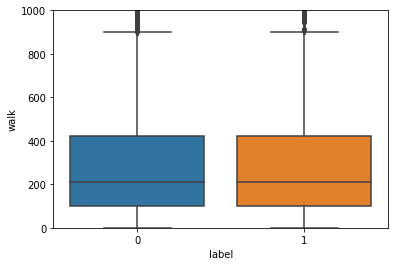

In [48]:
ax = sns.boxplot(x="label", y="walk",
                 data=hf_df_processed)
ax.set(ylim=(0, 1000))

[(0, 1000)]

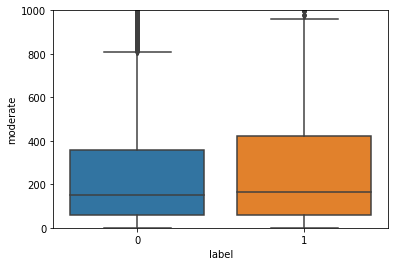

In [49]:
ax = sns.boxplot(x="label", y="moderate",
                 data=hf_df_processed)
ax.set(ylim=(0, 1000))

[(0, 500)]

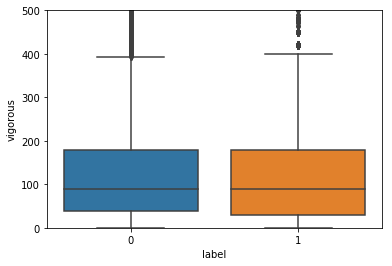

In [50]:
ax = sns.boxplot(x="label", y="vigorous",
                 data=hf_df_processed)
ax.set(ylim=(0, 500))

### Check mean acceleration

In [51]:
hf_df_processed.groupby('label')['Overall_acceleration_average'].median()

label
0    27.14
1    22.20
Name: Overall_acceleration_average, dtype: float64

[(0, 100)]

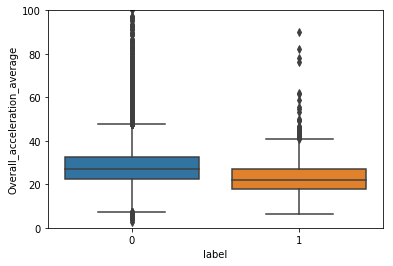

In [52]:
ax = sns.boxplot(x="label", y="Overall_acceleration_average",
                 data=hf_df_processed)
ax.set(ylim=(0, 100))

### Age

In [53]:
hf_df_processed.groupby('label')[['Age_at_recruitment']].mean()

,Age_at_recruitment
label,
0,56.346744
1,62.122693


[(0, 100)]

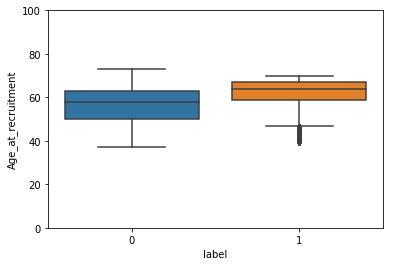

In [54]:
ax = sns.boxplot(x="label", y="Age_at_recruitment",
                 data=hf_df_processed)
ax.set(ylim=(0, 100))

### Sex

In [55]:
hf_df_processed.groupby('label')['Sex'].value_counts()

label  Sex
0      0.0    267729
       1.0    218823
1      1.0     10268
       0.0      5609
Name: Sex, dtype: int64

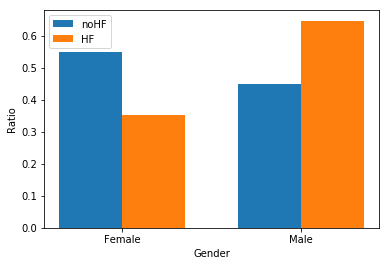

In [56]:
gender_count=hf_df_processed.groupby('label')['Sex'].value_counts()
sum_noHF=sum(gender_count[0])
sum_HF=sum(gender_count[1])
normalize_HF_by_grade=gender_count[1]/sum_HF
normalize_noHF_by_grade=gender_count[0]/sum_noHF
normalize_noHF_by_grade.sort_index(inplace=True)
normalize_HF_by_grade.sort_index(inplace=True)
fig, ax = plt.subplots()
width = 0.35  # the width of the bars
labels=['Female','Male']
positions=[0,1]
x=np.arange(len(labels))
rects1 = ax.bar(x - width/2, normalize_noHF_by_grade, width, label='noHF')
rects2 = ax.bar(x + width/2, normalize_HF_by_grade, width, label='HF')
#ax.bar(normalize_noHF_by_grade)
#ax.bar(normalize_HF_by_grade)
ax.legend()
plt.xticks(positions, labels)
plt.ylabel('Ratio')
plt.xlabel('Gender')

plt.show()

### BMI

In [57]:
hf_df_processed.groupby('label')['bmi_average'].mean()

label
0    27.349703
1    29.964303
Name: bmi_average, dtype: float64

In [58]:
hf_df_processed.groupby('label')[['bmi_average']].mean()

,bmi_average
label,
0,27.349703
1,29.964303


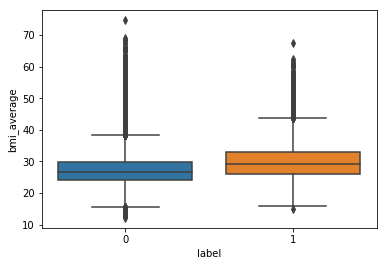

In [59]:
ax = sns.boxplot(x="label", y="bmi_average",
                 data=hf_df_processed)

### Townsend deprivation

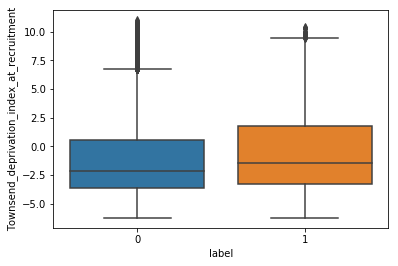

In [60]:
ax = sns.boxplot(x="label", y="Townsend_deprivation_index_at_recruitment",
                 data=hf_df_processed)
#ax.set(ylim=(0, 10))

### Cholesterol

[(0, 10)]

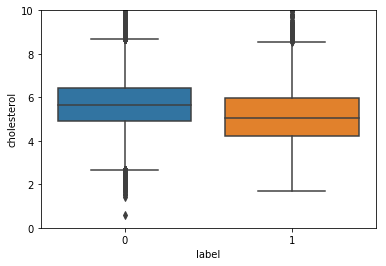

In [61]:
ax = sns.boxplot(x="label", y="cholesterol",
                 data=hf_df_processed)
ax.set(ylim=(0, 10))

### TV

[(0, 10)]

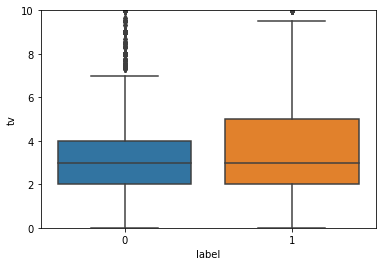

In [62]:
ax = sns.boxplot(x="label", y="tv",
                 data=hf_df_processed)
ax.set(ylim=(0, 10))

### Computer

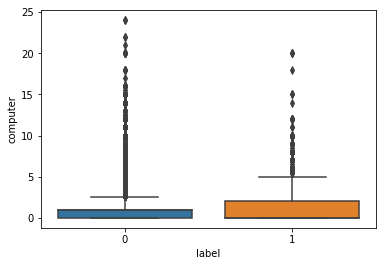

In [63]:
ax = sns.boxplot(x="label", y="computer",
                 data=hf_df_processed)


### Walk

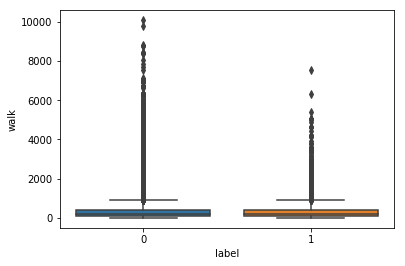

In [64]:
ax = sns.boxplot(x="label", y="walk",
                 data=hf_df_processed)
#ax.set(ylim=(0, 10))

### Sleep

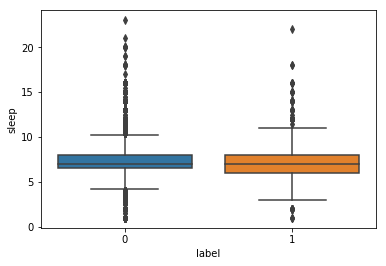

In [65]:
ax = sns.boxplot(x="label", y="sleep",
                 data=hf_df_processed)


### Alcohol

[(0, 10)]

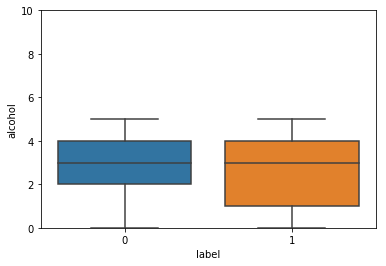

In [66]:
ax = sns.boxplot(x="label", y="alcohol",
                 data=hf_df_processed)
ax.set(ylim=(0, 10))

### Smoking

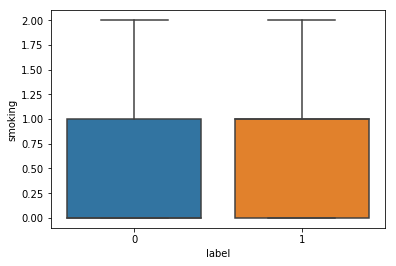

In [67]:
ax = sns.boxplot(x="label", y="smoking",
                 data=hf_df_processed)


### Blood test

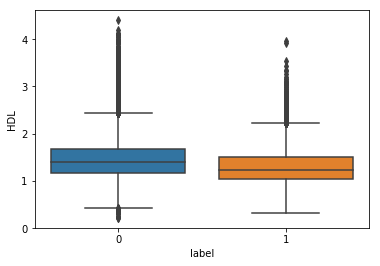

In [68]:
ax = sns.boxplot(x="label", y="HDL",
                 data=hf_df_processed)

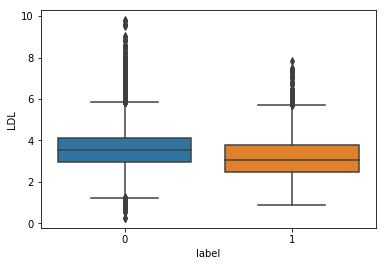

In [69]:
ax = sns.boxplot(x="label", y="LDL",
                 data=hf_df_processed)

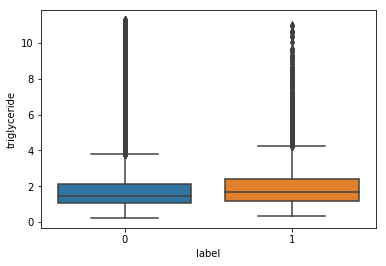

In [70]:
ax = sns.boxplot(x="label", y="triglyceride",
                 data=hf_df_processed)

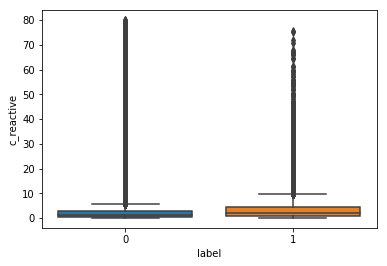

In [71]:
ax = sns.boxplot(x="label", y="c_reactive",
                 data=hf_df_processed)

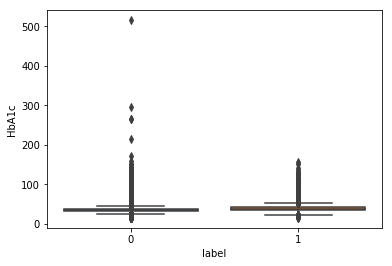

In [72]:
ax = sns.boxplot(x="label", y="HbA1c",
                 data=hf_df_processed)

### Food

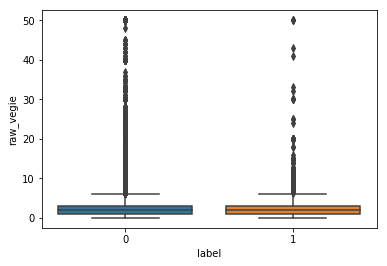

In [73]:
ax = sns.boxplot(x="label", y="raw_vegie",
                 data=hf_df_processed)

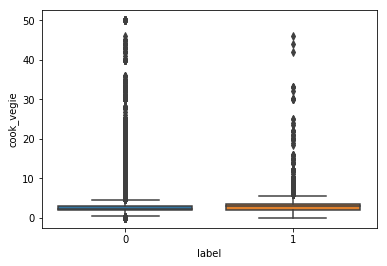

In [74]:
ax = sns.boxplot(x="label", y="cook_vegie",
                 data=hf_df_processed)

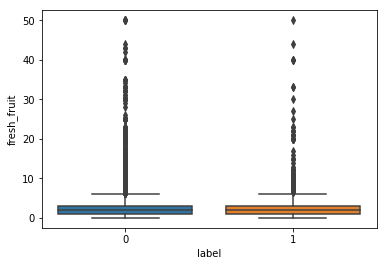

In [75]:
ax = sns.boxplot(x="label", y="fresh_fruit",
                 data=hf_df_processed)

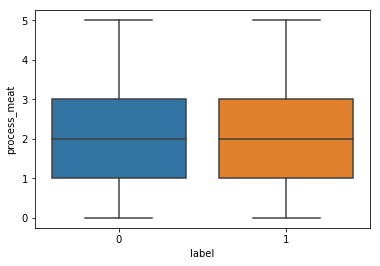

In [76]:
ax = sns.boxplot(x="label", y="process_meat",
                 data=hf_df_processed)

In [77]:
hf_df_processed=hf_df_processed.drop(columns=[
    'townsend_grade','acceleration_grade','bmi_grade'
                          ],inplace=False)


In [78]:
missing_value_count=hf_df_processed.isna().sum().sort_values()

In [79]:
100*missing_value_count.sort_values()/hf_df_processed.shape[0]


Age_at_recruitment                            0.000000
Sex                                           0.000000
label                                         0.000000
caucasian                                     0.000000
Townsend_deprivation_index_at_recruitment     0.123998
alcohol                                       0.292181
process_meat                                  0.431504
smoking                                       0.560875
bmi_average                                   0.596701
fresh_fruit                                   0.625362
sleep                                         0.809070
tv                                            1.038754
cook_vegie                                    1.453141
raw_vegie                                     1.497127
computer                                      1.648591
cholesterol                                   6.299995
triglyceride                                  6.373637
LDL                                           6.466784
c_reactive

#### We gonna remove Overall_acceleration_average later for multivariate or ML analysis due to its high missing value. 

### Save to csv for R and other stat analyhsis

In [ ]:
hf_df_processed.to_csv('hf_df_processed.csv',na_rep='NA',index=False)

In [96]:
! dx upload hf_df_processed.csv  --path /ASHGdemo/hf_df_processed.csv

[===========================================================>] Uploaded 59,891,222 of 59,891,222 bytes (100%) hf_df_processed.csv
ID                    file-G5J2Kj0J51ZbyGYQ07qF3yx4
Class                 file
Project               project-G59Y0xQJ51ZZFXpfFpfxQZzj
Folder                /ASHGdemo
Name                  hf_df_processed.csv
State                 closing
Visibility            visible
Types                 -
Properties            -
Tags                  -
Outgoing links        -
Created               Sun Oct  3 21:57:52 2021
Created by            chai_rap
 via the job          job-G5J18BjJ51ZykpKb078JbVP5
Last modified         Sun Oct  3 21:57:55 2021
Media type            
archivalState         "live"
cloudAccount          "cloudaccount-dnanexus"


### Once again, we may start from hf_df_processed.csv going foward. 

#### here is how to load data as CSV

`hf_df_processed = pd.read_csv('hf_df_processed.csv', sep=',')`

#### check datatype

`hf_df_processed.info()`

#### change to use categorical

`hf_df_processed['label']=hf_df_processed['label'].astype('category')`

`hf_df_processed['Sex']=hf_df_processed['Sex'].astype('category')`

`hf_df_processed['caucasian']=hf_df_processed['caucasian'].astype('category')`

#### check datatype again

`hf_df_processed.info()`


# 8. Basic machine learning

### Install all modules we will use and import them

In [1]:
pip install seaborn==0.11.1

     |████████████████████████████████| 285 kB 48.8 MB/s eta 0:00:01
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.10.1
    Uninstalling seaborn-0.10.1:
      Successfully uninstalled seaborn-0.10.1
Note: you may need to restart the kernel to use updated packages.


In [2]:
! pip install -U imbalanced-learn

     |████████████████████████████████| 189 kB 18.6 MB/s eta 0:00:01
     |████████████████████████████████| 303 kB 88.6 MB/s eta 0:00:01
     |████████████████████████████████| 22.2 MB 85.2 MB/s eta 0:00:01


In [3]:
! pip install sklearn

  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1317 sha256=5591bcc0a80505b4090a258c1066e9f629fd67cedc1a189297b550174cb084e8
  Stored in directory: /tmp/pip-ephem-wheel-cache-snua8rz3/wheels/23/9d/42/5ec745cbbb17517000a53cecc49d6a865450d1f5cb16dc8a9c
Successfully built sklearn


In [4]:
pip install xgboost

     |████████████████████████████████| 166.7 MB 169.6 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install lightgbm

     |████████████████████████████████| 2.0 MB 18.6 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install shap

     |████████████████████████████████| 356 kB 29.8 MB/s eta 0:00:01
     |████████████████████████████████| 3.4 MB 124.9 MB/s eta 0:00:01
     |████████████████████████████████| 25.3 MB 68.4 MB/s eta 0:00:01
  Created wheel for shap: filename=shap-0.39.0-cp36-cp36m-linux_x86_64.whl size=493156 sha256=c25fd811fc42f744c06feef46d0f02d0792d440fd89ad04828e78d3a3b5c777f
  Stored in directory: /tmp/pip-ephem-wheel-cache-pom0o6fo/wheels/6f/08/25/2992725334291786ea084e06cac493d93049b80e3470318a1b
Successfully built shap
Note: you may need to restart the kernel to use updated packages.


In [8]:
! pip install interpret==0.2.6

     |████████████████████████████████| 6.6 MB 36.5 MB/s eta 0:00:01
     |████████████████████████████████| 23.9 MB 125.7 MB/s eta 0:00:01
     |████████████████████████████████| 5.6 MB 114.1 MB/s eta 0:00:01
     |████████████████████████████████| 7.3 MB 130.9 MB/s eta 0:00:01
     |████████████████████████████████| 3.6 MB 95.3 MB/s eta 0:00:01
     |████████████████████████████████| 86 kB 102.2 MB/s eta 0:00:01
     |████████████████████████████████| 756 kB 128.2 MB/s eta 0:00:01
     |████████████████████████████████| 275 kB 124.2 MB/s eta 0:00:01
     |████████████████████████████████| 94 kB 90.4 MB/s  eta 0:00:01
     |████████████████████████████████| 288 kB 120.6 MB/s eta 0:00:01
     |████████████████████████████████| 133 kB 127.2 MB/s eta 0:00:01
     |████████████████████████████████| 251 kB 116.5 MB/s eta 0:00:01
     |████████████████████████████████| 147 kB 110.7 MB/s eta 0:00:01
     |████████████████████████████████| 12.4 MB 73.0 MB/s eta 0:00:01
     |█████████████████

## restart kernal here and import all the package we need

In [1]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import BalancedRandomForestClassifier

In [2]:
from IPython.display import Image

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import json
from collections import Counter


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, log_loss


In [5]:
from xgboost import XGBClassifier


In [6]:
from lightgbm import LGBMClassifier

In [7]:
from interpret.provider import InlineProvider
from interpret import set_visualize_provider

set_visualize_provider(InlineProvider())

In [8]:
from interpret import show
from interpret.data import ClassHistogram

In [9]:
from interpret import set_show_addr, get_show_addr 
from interpret.glassbox import ExplainableBoostingClassifier


## Load data from CSV

In [10]:
! dx download /ASHGdemo/hf_df_processed.csv

[===========================================================>] Completed 59,891,222 of 59,891,222 bytes (100%) /opt/notebooks/hf_df_processed.csvv


In [11]:
hf_df_processed = pd.read_csv('hf_df_processed.csv', sep=',')
hf_df_processed['label']=hf_df_processed['label'].astype('category')
hf_df_processed['Sex']=hf_df_processed['Sex'].astype('category')
hf_df_processed['caucasian']=hf_df_processed['caucasian'].astype('category')

In [12]:
hf_df_processed.shape

(502429, 25)

In [13]:
hf_df_processed.dropna(subset=['label'],inplace=True)

In [14]:
hf_df_processed.shape

(502429, 25)

In [37]:
hf_df_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 502429 entries, 0 to 502428
Data columns (total 25 columns):
Overall_acceleration_average                 96676 non-null float64
Townsend_deprivation_index_at_recruitment    501806 non-null float64
Age_at_recruitment                           502429 non-null float64
Sex                                          502429 non-null category
label                                        502429 non-null category
caucasian                                    502429 non-null category
walk                                         431158 non-null float64
moderate                                     377664 non-null float64
vigorous                                     280100 non-null float64
bmi_average                                  499431 non-null float64
sleep                                        498364 non-null float64
alcohol                                      500961 non-null float64
tv                                           497210 non-nul

In [15]:
hf_df_processed.isna().sum().sort_values()

Age_at_recruitment                                0
Sex                                               0
label                                             0
caucasian                                         0
Townsend_deprivation_index_at_recruitment       623
alcohol                                        1468
process_meat                                   2168
smoking                                        2818
bmi_average                                    2998
fresh_fruit                                    3142
sleep                                          4065
tv                                             5219
cook_vegie                                     7301
raw_vegie                                      7522
computer                                       8283
cholesterol                                   31653
triglyceride                                  32023
LDL                                           32491
c_reactive                                    32642
HbA1c       

In [16]:
hf_df_processed.isna().sum().sort_values()*100/(hf_df_processed.shape[0])

Age_at_recruitment                            0.000000
Sex                                           0.000000
label                                         0.000000
caucasian                                     0.000000
Townsend_deprivation_index_at_recruitment     0.123998
alcohol                                       0.292181
process_meat                                  0.431504
smoking                                       0.560875
bmi_average                                   0.596701
fresh_fruit                                   0.625362
sleep                                         0.809070
tv                                            1.038754
cook_vegie                                    1.453141
raw_vegie                                     1.497127
computer                                      1.648591
cholesterol                                   6.299995
triglyceride                                  6.373637
LDL                                           6.466784
c_reactive

## Remove feature with high missing value

In [17]:
hf_df_good_measure=hf_df_processed.drop(columns=['Overall_acceleration_average'])

## Separate between full data set and dataset with no missing value(Complete Case Analysis)

In [18]:
hf_df_good_measure.label.value_counts()

0    486552
1     15877
Name: label, dtype: int64

In [19]:
CCA_hf_df_good_measure=hf_df_good_measure.dropna()

In [20]:
CCA_hf_df_good_measure.shape

(200218, 24)

In [21]:
CCA_hf_df_good_measure.label.value_counts()

0    195842
1      4376
Name: label, dtype: int64

## Use downsampling to balance class and separate out label

In [22]:
X = hf_df_good_measure.drop(columns=['label'])
y = hf_df_good_measure['label']

In [23]:
counter = Counter(y)
estimate = counter[0] / counter[1]
estimate

30.645084083894943

In [24]:
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X, y)

In [25]:
y_resampled.value_counts()

1    15877
0    15877
Name: label, dtype: int64

In [26]:
CCA_X = CCA_hf_df_good_measure.drop(columns=['label'])
CCA_y = CCA_hf_df_good_measure['label']
counter = Counter(CCA_y)
CCA_estimate = counter[0] / counter[1]   
CCA_estimate

44.7536563071298

In [27]:
rus = RandomUnderSampler(random_state=0)
CCA_X_resampled, CCA_y_resampled = rus.fit_resample(CCA_X, CCA_y)

In [28]:
CCA_y_resampled.value_counts()

1    4376
0    4376
Name: label, dtype: int64

In [29]:
## One hot encoding categorical 

In [30]:
object_cols=['Sex','caucasian']

In [31]:
X_train, X_valid, y_train, y_valid = train_test_split(X_resampled , y_resampled , train_size=0.8, test_size=0.2,
                                                                random_state=0)

In [32]:
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[object_cols]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(X_valid[object_cols]))

# One-hot encoding removed index; put it back
OH_cols_train.index = X_train.index
OH_cols_valid.index = X_valid.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X_train.drop(object_cols, axis=1)
num_X_valid = X_valid.drop(object_cols, axis=1)

# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)

In [33]:
CCA_X_train, CCA_X_valid, CCA_y_train, CCA_y_valid = train_test_split(CCA_X_resampled , CCA_y_resampled , train_size=0.8, test_size=0.2,
                                                                random_state=0)

In [34]:
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(CCA_X_train[object_cols]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(CCA_X_valid[object_cols]))

# One-hot encoding removed index; put it back
OH_cols_train.index = CCA_X_train.index
OH_cols_valid.index = CCA_X_valid.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = CCA_X_train.drop(object_cols, axis=1)
num_X_valid = CCA_X_valid.drop(object_cols, axis=1)

# Add one-hot encoded columns to numerical features
OH_CCA_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_CCA_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)

## Run multiple ML prediction model

Run models in the following order:

    * XGboosted on full dataset
    * XGboosted on CCA (no missing value)
    * lightGBM on full dataset
    * lightGBM on CCA
    * random forest on CCA
    * logistic regression on CCA
    * Explaininable boosting machine (EBM) on CCA

Note that random forest, logistic regression, and EBM can't handle missing values, so we only use them on CCA.
    

In [38]:
xgb_full= XGBClassifier(n_estimators=1000)
xgb_full.fit(OH_X_train,y_train,early_stopping_rounds=5,
            eval_set=[(OH_X_valid, y_valid)],eval_metric=['auc','logloss'])

[0]	validation_0-auc:0.77241	validation_0-logloss:0.63361
[1]	validation_0-auc:0.78435	validation_0-logloss:0.60011
[2]	validation_0-auc:0.79127	validation_0-logloss:0.57881
[3]	validation_0-auc:0.79397	validation_0-logloss:0.56613
[4]	validation_0-auc:0.79622	validation_0-logloss:0.55774
[5]	validation_0-auc:0.79775	validation_0-logloss:0.55171
[6]	validation_0-auc:0.79798	validation_0-logloss:0.54859
[7]	validation_0-auc:0.79900	validation_0-logloss:0.54561


/opt/conda/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[8]	validation_0-auc:0.79912	validation_0-logloss:0.54432
[9]	validation_0-auc:0.79930	validation_0-logloss:0.54365
[10]	validation_0-auc:0.79970	validation_0-logloss:0.54286
[11]	validation_0-auc:0.80093	validation_0-logloss:0.54143
[12]	validation_0-auc:0.80073	validation_0-logloss:0.54143
[13]	validation_0-auc:0.80059	validation_0-logloss:0.54148
[14]	validation_0-auc:0.80093	validation_0-logloss:0.54128
[15]	validation_0-auc:0.80096	validation_0-logloss:0.54158
[16]	validation_0-auc:0.80079	validation_0-logloss:0.54198
[17]	validation_0-auc:0.79981	validation_0-logloss:0.54317
[18]	validation_0-auc:0.79897	validation_0-logloss:0.54408
[19]	validation_0-auc:0.79878	validation_0-logloss:0.54447


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [39]:
xgb_CCA= XGBClassifier(n_estimators=1000)
xgb_CCA.fit(OH_CCA_X_train,CCA_y_train,early_stopping_rounds=5,
            eval_set=[(OH_CCA_X_valid, CCA_y_valid)],eval_metric=['auc','logloss'])

[0]	validation_0-auc:0.77514	validation_0-logloss:0.63032
[1]	validation_0-auc:0.78832	validation_0-logloss:0.59537
[2]	validation_0-auc:0.79059	validation_0-logloss:0.57656
[3]	validation_0-auc:0.79141	validation_0-logloss:0.56565
[4]	validation_0-auc:0.79210	validation_0-logloss:0.55930
[5]	validation_0-auc:0.79431	validation_0-logloss:0.55376
[6]	validation_0-auc:0.79501	validation_0-logloss:0.55090
[7]	validation_0-auc:0.79607	validation_0-logloss:0.54890
[8]	validation_0-auc:0.79471	validation_0-logloss:0.55021
[9]	validation_0-auc:0.79479	validation_0-logloss:0.55017
[10]	validation_0-auc:0.79426	validation_0-logloss:0.55005
[11]	validation_0-auc:0.79387	validation_0-logloss:0.55000
[12]	validation_0-auc:0.79243	validation_0-logloss:0.55148


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [40]:
lgbm_full=LGBMClassifier(n_estimators=1000)
lgbm_full.fit(OH_X_train,y_train,early_stopping_rounds=5,
            eval_set=[(OH_X_valid, y_valid)],eval_metric=['auc','logloss'])

[1]	valid_0's auc: 0.772643	valid_0's binary_logloss: 0.671285
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.775811	valid_0's binary_logloss: 0.653643
[3]	valid_0's auc: 0.780335	valid_0's binary_logloss: 0.638838
[4]	valid_0's auc: 0.785021	valid_0's binary_logloss: 0.625678
[5]	valid_0's auc: 0.786901	valid_0's binary_logloss: 0.614989
[6]	valid_0's auc: 0.789534	valid_0's binary_logloss: 0.605525
[7]	valid_0's auc: 0.790957	valid_0's binary_logloss: 0.59748
[8]	valid_0's auc: 0.792706	valid_0's binary_logloss: 0.590313
[9]	valid_0's auc: 0.793346	valid_0's binary_logloss: 0.584428
[10]	valid_0's auc: 0.794541	valid_0's binary_logloss: 0.579038
[11]	valid_0's auc: 0.795642	valid_0's binary_logloss: 0.574121
[12]	valid_0's auc: 0.796432	valid_0's binary_logloss: 0.570037
[13]	valid_0's auc: 0.797524	valid_0's binary_logloss: 0.566247
[14]	valid_0's auc: 0.797807	valid_0's binary_logloss: 0.563194
[15]	valid_0's auc: 0.798371	valid_0's binary_logloss:

LGBMClassifier(n_estimators=1000)

In [41]:
lgbm_CCA=LGBMClassifier(n_estimators=1000)
lgbm_CCA.fit(OH_CCA_X_train,CCA_y_train,early_stopping_rounds=5,
            eval_set=[(OH_CCA_X_valid, CCA_y_valid)],eval_metric=['auc','logloss'])

[1]	valid_0's auc: 0.778838	valid_0's binary_logloss: 0.669841
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.781978	valid_0's binary_logloss: 0.650751
[3]	valid_0's auc: 0.784785	valid_0's binary_logloss: 0.635463
[4]	valid_0's auc: 0.786345	valid_0's binary_logloss: 0.622707
[5]	valid_0's auc: 0.792154	valid_0's binary_logloss: 0.610546
[6]	valid_0's auc: 0.793773	valid_0's binary_logloss: 0.601072
[7]	valid_0's auc: 0.793624	valid_0's binary_logloss: 0.593174
[8]	valid_0's auc: 0.79287	valid_0's binary_logloss: 0.587078
[9]	valid_0's auc: 0.791903	valid_0's binary_logloss: 0.582107
[10]	valid_0's auc: 0.793043	valid_0's binary_logloss: 0.577035
[11]	valid_0's auc: 0.792864	valid_0's binary_logloss: 0.573204
Early stopping, best iteration is:
[6]	valid_0's auc: 0.793773	valid_0's binary_logloss: 0.601072


LGBMClassifier(n_estimators=1000)

In [42]:
forest_CCA = RandomForestClassifier(n_estimators=100,random_state=0)
forest_CCA.fit(OH_CCA_X_train,CCA_y_train)

RandomForestClassifier(random_state=0)

In [43]:
logistic_CCA=LogisticRegression(random_state=0,solver='lbfgs',max_iter=10000)# solver='saga')
logistic_CCA.fit(OH_CCA_X_train,CCA_y_train)

LogisticRegression(max_iter=10000, random_state=0)

In [44]:
ebm_CCA = ExplainableBoostingClassifier(random_state=127,max_rounds=5000)
ebm_CCA.fit(CCA_X_train, CCA_y_train) 

ExplainableBoostingClassifier(feature_names=['Townsend_deprivation_index_at_recruitment',
                                             'Age_at_recruitment', 'Sex',
                                             'caucasian', 'walk', 'moderate',
                                             'vigorous', 'bmi_average', 'sleep',
                                             'alcohol', 'tv', 'computer',
                                             'smoking', 'cholesterol', 'HDL',
                                             'LDL', 'triglyceride',
                                             'c_reactive', 'HbA1c', 'raw_vegie',
                                             'cook_vegie', 'fresh_fruit',
                                             'process_meat',
                                             'Age_at_recruitment...
                                             'continuous', 'continuous',
                                             'continuous', 'continuous',
                           

## Use the following cells to analyze accuracy and F1 score in test and testing dataset for models that run on full dataset

In [45]:
model_full=lgbm_full
preds_train = model_full.predict(OH_X_train)
preds_val = model_full.predict(OH_X_valid)


In [46]:
accuracy_train=accuracy_score(y_train,preds_train)
accuracy_val=accuracy_score(y_valid,preds_val)
f1_train=f1_score(y_train,preds_train)
f1_val=f1_score(y_valid,preds_val)

print('predicted train {}'.format(Counter(preds_train)))
print('predicted valid {}'.format(Counter(preds_val)))
print('Train accuracy {} and F1 {}'.format(accuracy_train,f1_train))
print('Validation accuracy {} and F1 {}'.format(accuracy_val,f1_val))

predicted train Counter({1: 13145, 0: 12258})
predicted valid Counter({1: 3300, 0: 3051})
Train accuracy 0.7526276424044405 and F1 0.7566039197459137
Validation accuracy 0.7253975751850102 and F1 0.7318573185731858


## Use the following cells to analyze accuracy and F1 score in test and testing dataset for models that run on CCA

In [47]:
model_CCA=lgbm_CCA
preds_train = model_CCA.predict(OH_CCA_X_train)
preds_val = model_CCA.predict(OH_CCA_X_valid)

In [48]:
accuracy_train=accuracy_score(CCA_y_train,preds_train)
accuracy_val=accuracy_score(CCA_y_valid,preds_val)
f1_train=f1_score(CCA_y_train,preds_train)
f1_val=f1_score(CCA_y_valid,preds_val)

print('predicted train {}'.format(Counter(preds_train)))
print('predicted valid {}'.format(Counter(preds_val)))
print('Train accuracy {} and F1 {}'.format(accuracy_train,f1_train))
print('Validation accuracy {} and F1 {}'.format(accuracy_val,f1_val))

predicted train Counter({1: 3729, 0: 3272})
predicted valid Counter({1: 937, 0: 814})
Train accuracy 0.7477503213826596 and F1 0.756144711405689
Validation accuracy 0.7087378640776699 and F1 0.7166666666666667


### The exception is EBM which we dont' need one hot encoding

In [49]:
preds_train = ebm_CCA.predict(CCA_X_train)
preds_val = ebm_CCA.predict(CCA_X_valid)

### Here are results we get when make poster

# 9. Interpretable and explainable ML


In [50]:
import shap

In [51]:
print(shap.__version__)

0.39.0


### We will run SHAP on all model to investigate order of feature importance and their affects on each individual

In [52]:
explainer_xgb_full = shap.TreeExplainer(xgb_full)
shap_values_xgb_full = explainer_xgb_full.shap_values(OH_X_valid,approximate=True)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


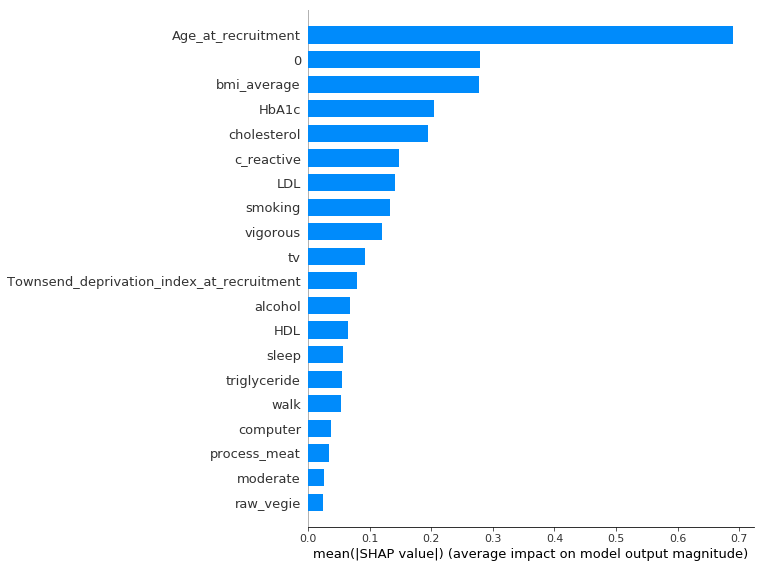

In [53]:
shap.summary_plot(shap_values_xgb_full, OH_X_valid,plot_type="bar")


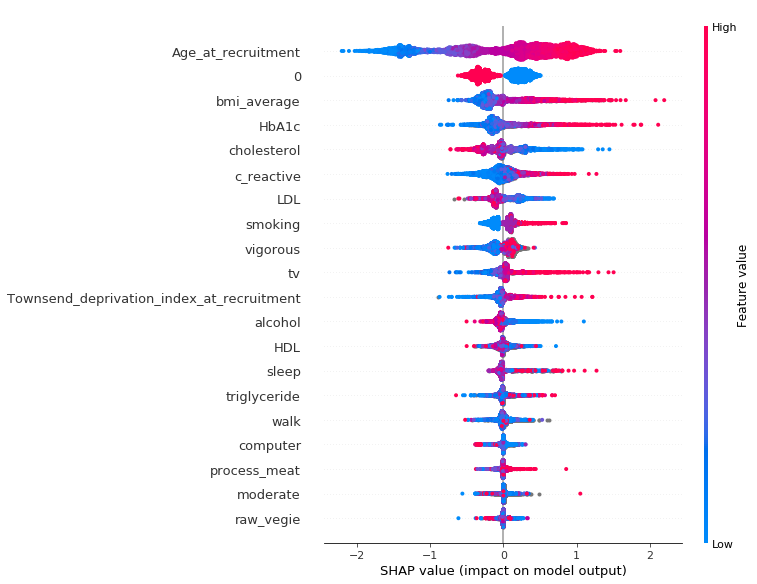

In [54]:
shap.summary_plot(shap_values_xgb_full, OH_X_valid)

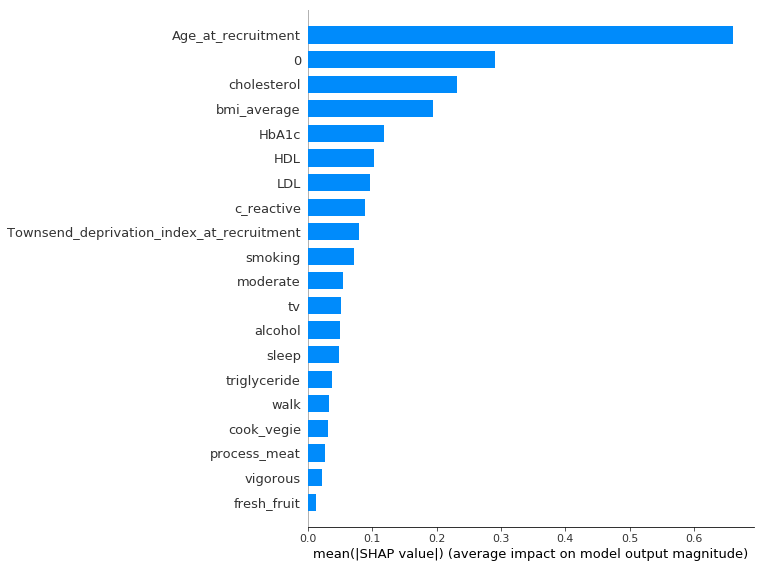

In [55]:
explainer_xgb_CCA = shap.TreeExplainer(xgb_CCA)
shap_values_xgb_CCA = explainer_xgb_CCA.shap_values(OH_CCA_X_train,approximate=True)
shap.summary_plot(shap_values_xgb_CCA, OH_CCA_X_train,plot_type="bar")

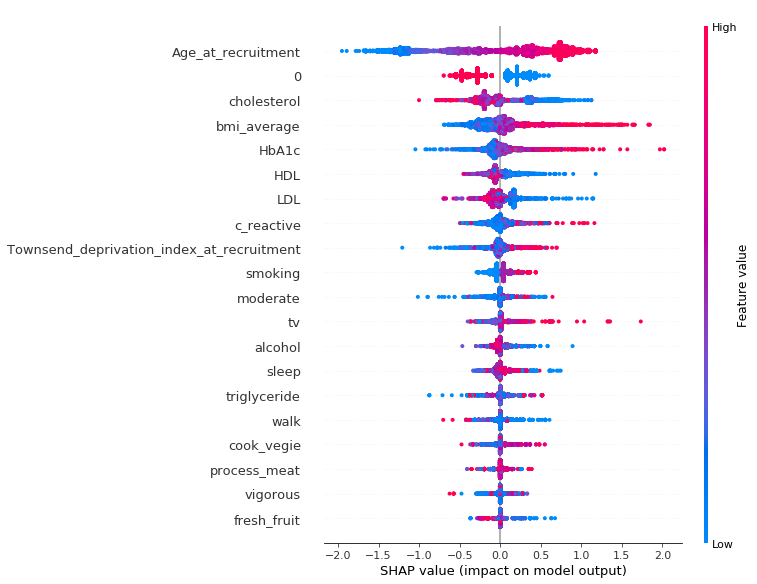

In [56]:
shap.summary_plot(shap_values_xgb_CCA, OH_CCA_X_train)


In [57]:
explainer_xgb_CCA2 = shap.TreeExplainer(xgb_CCA)
shap_values_xgb_CCA2 = explainer_xgb_CCA2.shap_values(OH_CCA_X_train)

In [58]:
shap_values_xgb_CCA2.shape

(7001, 25)

In [59]:
shap_values_xgb_CCA.shape

(7001, 25)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


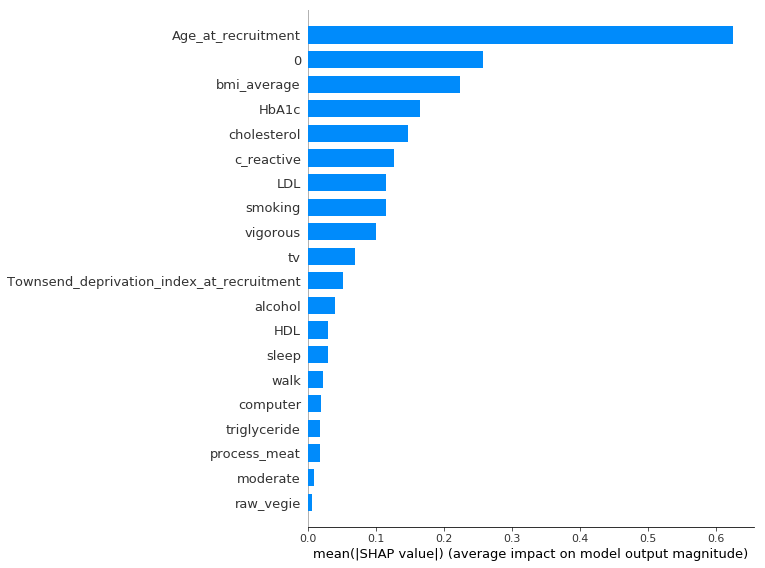

In [60]:
explainer_lgbm_full = shap.TreeExplainer(lgbm_full)
shap_values_lgbm_full = explainer_lgbm_full.shap_values(OH_X_valid)
shap.summary_plot(shap_values_lgbm_full[1], OH_X_valid,plot_type="bar")

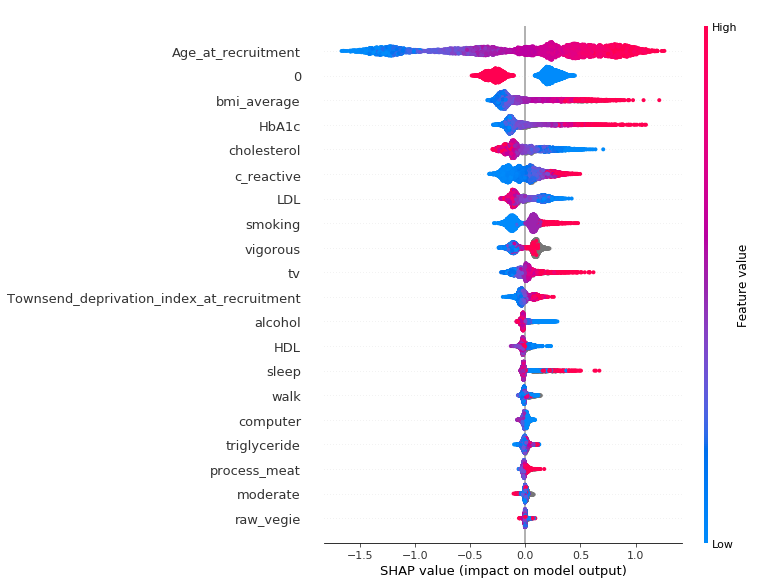

In [61]:
shap.summary_plot(shap_values_lgbm_full[1], OH_X_valid)

#### The lbgm_full has the best performance on test dataset, so we will also investigate partial dependent plot to see overall trend and scale of impact.

In [62]:
X100 = shap.utils.sample(OH_X_valid, 100)

In [63]:
OH_X_valid.columns

Index(['Townsend_deprivation_index_at_recruitment',
                              'Age_at_recruitment',
                                            'walk',
                                        'moderate',
                                        'vigorous',
                                     'bmi_average',
                                           'sleep',
                                         'alcohol',
                                              'tv',
                                        'computer',
                                         'smoking',
                                     'cholesterol',
                                             'HDL',
                                             'LDL',
                                    'triglyceride',
                                      'c_reactive',
                                           'HbA1c',
                                       'raw_vegie',
                                      'cook_vegie',
            

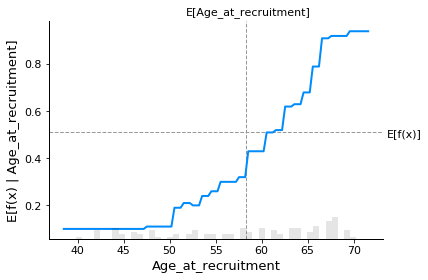

In [64]:
shap.plots.partial_dependence(
    "Age_at_recruitment", lgbm_full.predict, X100, ice=False,
    model_expected_value=True, feature_expected_value=True
)

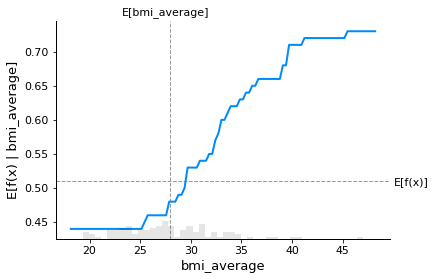

In [65]:
shap.plots.partial_dependence(
    "bmi_average", lgbm_full.predict, X100, ice=False,
    model_expected_value=True, feature_expected_value=True
)

invalid value encountered in greater_equal
invalid value encountered in less_equal


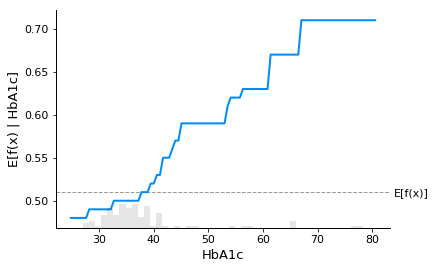

In [66]:
shap.plots.partial_dependence(
    "HbA1c", lgbm_full.predict, X100, ice=False,
    model_expected_value=True, feature_expected_value=True
)

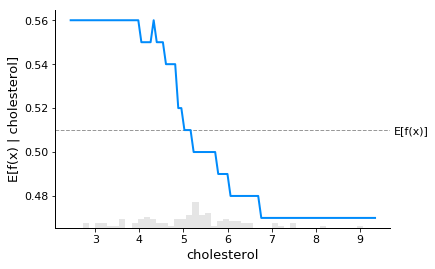

In [67]:
shap.plots.partial_dependence(
    "cholesterol", lgbm_full.predict, X100, ice=False,
    model_expected_value=True, feature_expected_value=True
)

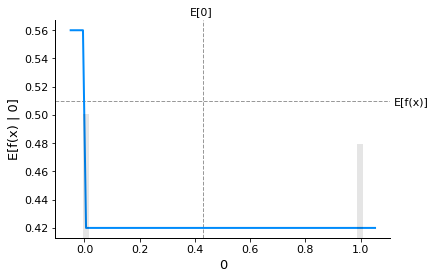

In [68]:
shap.plots.partial_dependence(
    -4, lgbm_full.predict, X100, ice=False,
    model_expected_value=True, feature_expected_value=True
)

Notice that it doesn't understand categorical feature and pick a different kind of plotting. Even though this is compresible, it would be better to use different visuzliation for categorical from numerical. We will address this later.

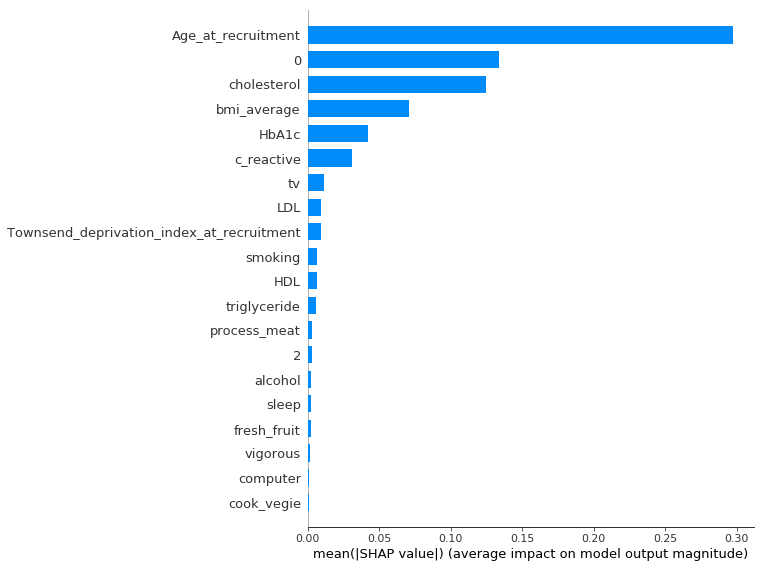

In [69]:
explainer_lgbm_CCA = shap.TreeExplainer(lgbm_CCA)
shap_values_lgbm_CCA = explainer_lgbm_CCA.shap_values(OH_CCA_X_train)
shap.summary_plot(shap_values_lgbm_CCA[1], OH_CCA_X_train,plot_type="bar")


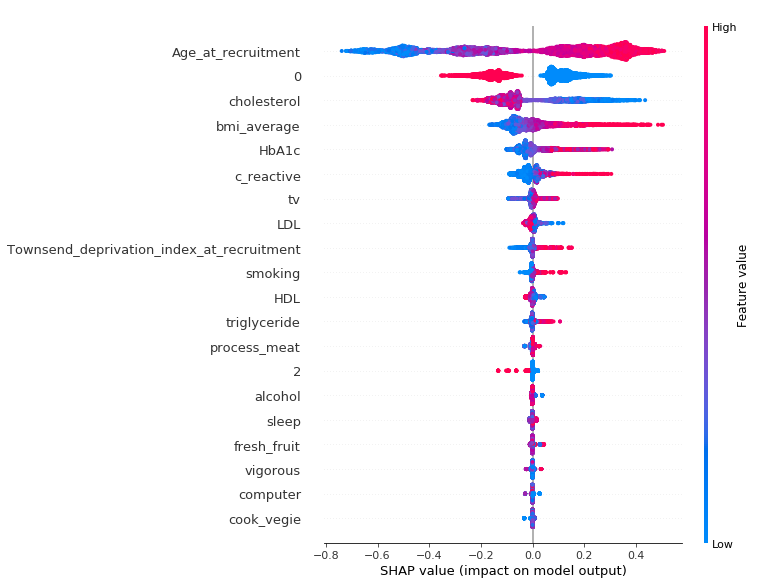

In [70]:
shap.summary_plot(shap_values_lgbm_CCA[1], OH_CCA_X_train)


In [71]:
print(len(shap_values_lgbm_CCA))
shap_values_lgbm_CCA[0].shape

2


(7001, 25)

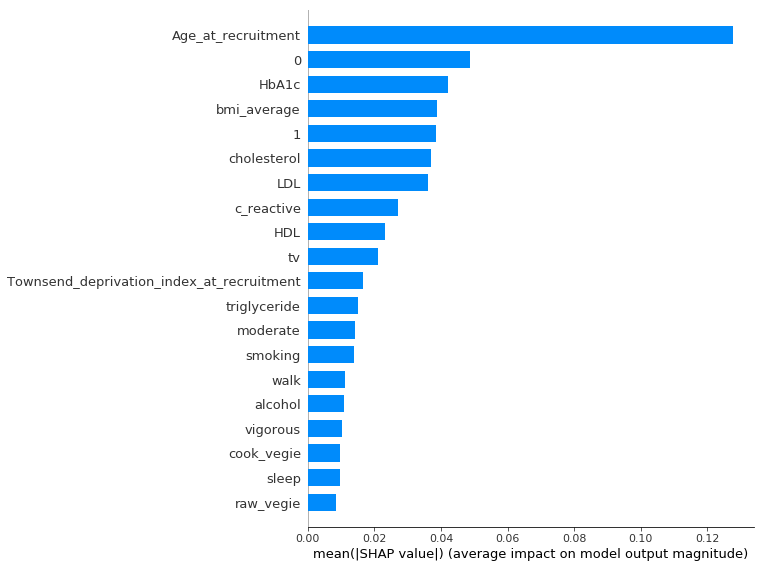

In [72]:
explainer_forest_CCA = shap.TreeExplainer(forest_CCA)
shap_values_forest_CCA = explainer_forest_CCA.shap_values(OH_CCA_X_valid,approximate=True)
shap.summary_plot(shap_values_forest_CCA[1], OH_CCA_X_valid,plot_type="bar")

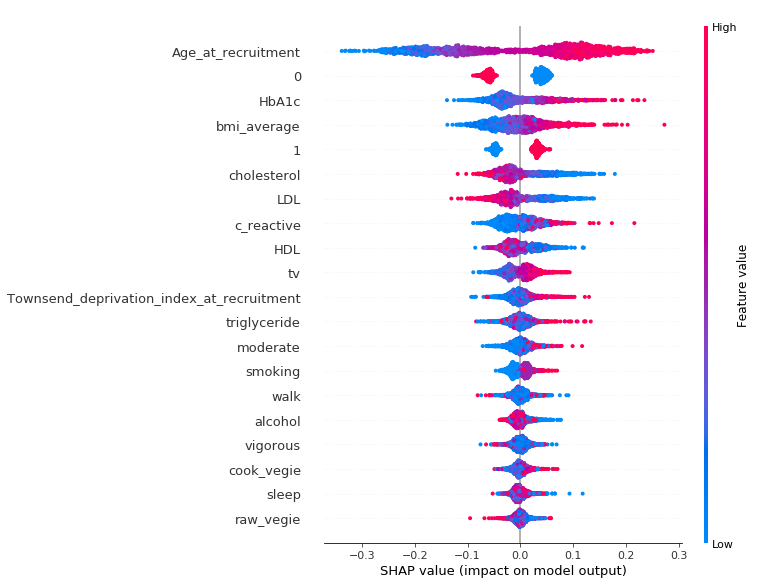

In [73]:
shap.summary_plot(shap_values_forest_CCA[1], OH_CCA_X_valid)

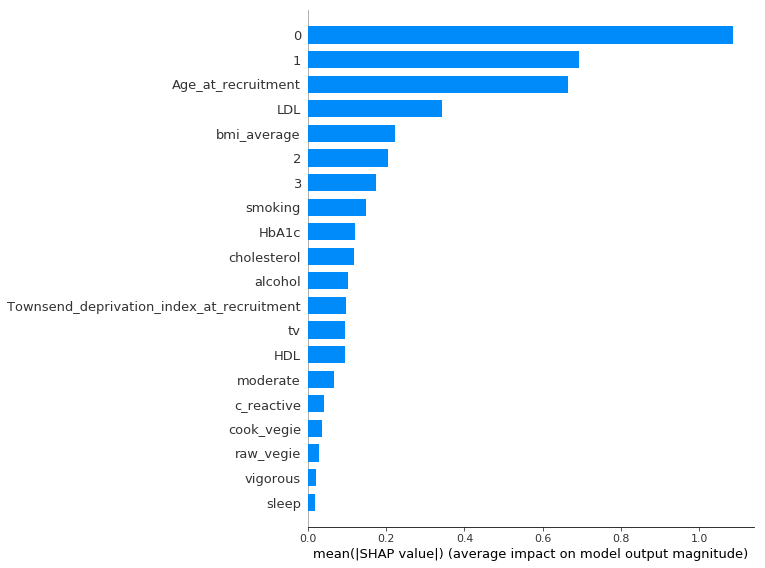

In [74]:
explainer_logistic_CCA = shap.Explainer(logistic_CCA,OH_CCA_X_valid)
shap_values_logistic_CCA = explainer_logistic_CCA(OH_CCA_X_valid)
shap.summary_plot(shap_values_logistic_CCA, OH_CCA_X_valid,plot_type="bar")

In [75]:
list(zip(list(logistic_CCA.coef_[0]),list(OH_CCA_X_valid.columns)))

[(0.04202299549592203, 'Townsend_deprivation_index_at_recruitment'),
 (0.10122149421214335, 'Age_at_recruitment'),
 (-2.2314417213750364e-05, 'walk'),
 (0.00020168248842127208, 'moderate'),
 (-0.0001701187041880166, 'vigorous'),
 (0.062062123201250693, 'bmi_average'),
 (-0.024220834523665892, 'sleep'),
 (-0.08325027152583524, 'alcohol'),
 (0.07837746914303481, 'tv'),
 (-0.02082230960733991, 'computer'),
 (0.25231868648575256, 'smoking'),
 (0.12064918705302012, 'cholesterol'),
 (-0.3086481161254983, 'HDL'),
 (-0.46777959010696, 'LDL'),
 (-0.02411373998650766, 'triglyceride'),
 (0.017991793732595716, 'c_reactive'),
 (0.02581905295527512, 'HbA1c'),
 (-0.0193602011159064, 'raw_vegie'),
 (0.028541411918278643, 'cook_vegie'),
 (0.006777899508001954, 'fresh_fruit'),
 (0.007873057439355128, 'process_meat'),
 (-2.216542728724212, 0),
 (-1.4141707167782178, 1),
 (-1.9641499767272759, 2),
 (-1.666563468761736, 3)]

One hot encoding for logis is hard to interpret. It is confusing which number represent what. Also, how come the pair number (0 vs 1 and 2 vs 3) have different value. We will try with non-one hot encoding instead.

In [76]:
logistic_CCA_noOH=LogisticRegression(random_state=0,solver='lbfgs',max_iter=10000)# solver='saga')
logistic_CCA_noOH.fit(CCA_X_train,CCA_y_train)

LogisticRegression(max_iter=10000, random_state=0)

In [77]:
preds_train = logistic_CCA_noOH.predict(CCA_X_train)
preds_val = logistic_CCA_noOH.predict(CCA_X_valid)
accuracy_train=accuracy_score(CCA_y_train,preds_train)
accuracy_val=accuracy_score(CCA_y_valid,preds_val)
f1_train=f1_score(CCA_y_train,preds_train)
f1_val=f1_score(CCA_y_valid,preds_val)
print('predicted train {}'.format(Counter(preds_train)))
print('predicted valid {}'.format(Counter(preds_val)))
print('Train accuracy {} and F1 {}'.format(accuracy_train,f1_train))
print('Validation accuracy {} and F1 {}'.format(accuracy_val,f1_val))

predicted train Counter({1: 3592, 0: 3409})
predicted valid Counter({1: 904, 0: 847})
Train accuracy 0.7230395657763177 and F1 0.7270935960591134
Validation accuracy 0.7161621930325528 and F1 0.7187323146576118


Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.


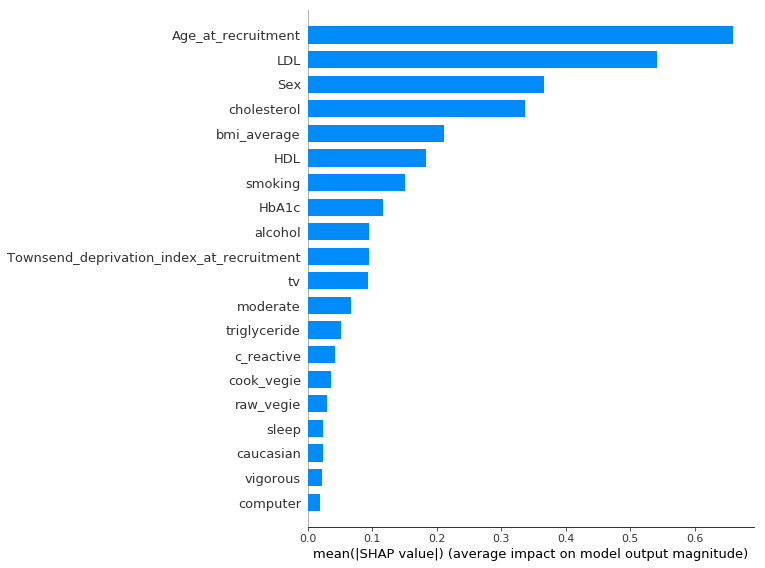

In [78]:
explainer_logistic_CCA_noOH = shap.Explainer(logistic_CCA_noOH,CCA_X_valid)
shap_values_logistic_CCA_noOH = explainer_logistic_CCA_noOH(CCA_X_valid)
shap.summary_plot(shap_values_logistic_CCA_noOH, CCA_X_valid,plot_type="bar")

This model has lower predictive power than its one-hot encoding correspondance.

### Finally, the EBM. Rather than running SHAP which is not current support, we will use build-in interpret feature to inspect global feature imporant and partial dependent plot instead

In [81]:
ebm_CCA_global = ebm_CCA.explain_global(name='EBM')
show(ebm_CCA_global)

In the poster, we use SHAP analysis for most important features for each model (except EBM which has its own). All boosted tree model have similar predictive power and most important feature with lightGBM full has highest validation F1. However, we choose to show partial dependent plot and population density from EBM (package interpretML/interpret) since it's easier to understand. 

Thanks for reading this notebook. Hope this example here would be useful for your research.